In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import scipy.linalg as LA
from scipy.signal import lsim, dlsim
import opentorsion as ot
import cvxpy as cp

In [2]:
plt.style.use(['science', 'ieee'])
plt.rcParams["figure.figsize"] = (6,4)

# Three-degree-of-freedom model

In [3]:
def drivetrain_3dof():
    """
    Mechanical drivetrain as an openTorsion assembly instance.

    Returns:
    assembly: opentorsion assembly instance
        A 3-DOF mechanical drivetrain modeled as lumped masses and flexible shafts
        (lumped mass - shaft - lumped mass - shaft - lumped mass).
    """
    # Disk 1 inertia
    J1 = 0.8
    # Disk 2 inertia
    J2 = 0.5
    # Disk 3 inertia
    J3 = 0.7
    # Shaft 1 stiffness
    k1 = 1.5e4
    # Shaft 2 stiffness
    k2 = 1e4

    disks, shafts = [], []
    shafts.append(ot.Shaft(0, 1, None, None, k=k1, I=0))
    shafts.append(ot.Shaft(1, 2, None, None, k=k2, I=0))
    disks.append(ot.Disk(0, I=J1))
    disks.append(ot.Disk(1, I=J2))
    disks.append(ot.Disk(2, I=J3))
    assembly = ot.Assembly(shafts, disk_elements=disks)
    _, f, _ = assembly.modal_analysis()

    return assembly

In [4]:
def state_matrices(assembly):
    """
    Create state-space matrices A and B of an openTorsion assembly.

    Parameters:
    assembly : openTorsion assembly instance
        Mechanical drivetrain model.

    Returns:
    A : numpy.ndarray
        The state matrix
    B : numpy.ndarray
        The input matrix
    """
    M, K = assembly.M(), assembly.K()  # Mass and stiffness matrices
    C = assembly.C_modal(M, K, xi=0.03)  # Modal damping matrix, modal damping coefficient 0.02 used
    Z = np.zeros(M.shape)
    I = np.eye(M.shape[0])
    M_inv = LA.inv(M)

    A = np.vstack([np.hstack([Z, I]), np.hstack([-M_inv @ K, -M_inv @ C])])

    B = np.vstack([Z, M_inv])

    return A, B

In [5]:
def X(k_values, ndof):
    """
    Used to transform the state-matrix to be compatible with shaft torque as a state.
    """
    rows = ndof-1
    cols = ndof
    if len(k_values) != rows:
        print("wrong amount of stiffness values / dofs")
        return
    
    X_up = np.zeros((rows, cols))
    X_down = np.eye(cols)
    Z_up = np.zeros(X_up.shape)
    Z_down = np.zeros(X_down.shape)
    
    for i in range(rows):
        X_up[i,i] = -k_values[i]
        X_up[i,i+1] = k_values[i]
    
    X = np.vstack([np.hstack([X_up, Z_up]), np.hstack([Z_down, X_down])])
    X_inv = X.T @ LA.inv(X @ X.T)
    
    return X, X_inv

In [6]:
def c2d(A, B, Ts):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time T_s.
    The function returns matrices A,B of the discrete-time system.
    """
    m, n = A.shape
    nb = B.shape[1]

    s = np.concatenate([A,B], axis=1)
    s = np.concatenate([s, np.zeros((nb, n+nb))], axis=0)
    S = LA.expm(s*Ts)
    Ad = S[0:n,0:n]
    Bd = S[0:n,n:n+nb+1]
    
    return Ad, Bd

In [7]:
def O(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    A_power = np.copy(A)
    O = np.vstack((np.copy(C), C @ A))
    
    for k in range(n-2):
        A_power = A_power @ A
        O = np.vstack((O, C @ A_power))

    return O

In [8]:
def gamma(A, B, C, n):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    A_power = np.copy(A)
    Z = np.zeros((C @ B).shape)
    
    # first column
    gamma_column_first = np.vstack((
        Z,
        C @ B, 
        C @ A @ B
    ))
    for _ in range(n-3):
        A_power = A_power @ A
        gamma_column_first = np.vstack((gamma_column_first, C @ A_power @ B))

    # build complete matrix, column by column, from left to right
    gamma = np.copy(gamma_column_first)
    current_column = 1
    for _ in range(1, n):
        gamma_rows = Z
        
        # first add zero matrices
        for _ in range(current_column):
            gamma_rows = np.vstack((gamma_rows, Z))
        
        # then add the impulse responses
        A_power2 = np.copy(A)
        
        if current_column < (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B,
                C @ A @ B # these must not be added to the last and the second to last columns
            ))
            
        if current_column == (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B # this has to be added to the end of the second to last column
            ))
        
        for _ in range(n-current_column-3):
            A_power2 = A_power2 @ A
            gamma_rows = np.vstack((gamma_rows, C @ A_power2 @ B))

        # add column on the right hand side
        gamma = np.hstack((gamma, gamma_rows))
        current_column += 1
    
    return gamma

In [9]:
def L(input_shape):
    '''
    The regularization matrix L.

    Parameters:

    input_shape : float
        Input vector shape used to determine L matrix shape.

    Returns:

    L : ndarray
        The regularization matrix
    '''
    L = np.eye(input_shape)

    return L

In [10]:
def second_difference_matrix(n, m):
    D2 = np.eye(n*m) - 2*np.eye(n*m, k=2) + np.eye(n*m, k=4)
    
    # delete incomplete rows
    D2 = D2[:-2*m, :]
    
    return D2

In [11]:
def tikhonov_problem(meas, obsrv, gamm, regu, initial_state=None, lam=1, cmplx=False):
    '''
    This function uses the cvxpy library to solve a Tikhonov regularization problem.
    '''
    d = cp.Variable((gamm.shape[1], 1), complex=cmplx)
    
    if initial_state is None:
        x = cp.Variable((obsrv.shape[1], 1), complex=cmplx)
    else:
        x = initial_state
        
    measurements = cp.Parameter(meas.shape)
    measurements.value = meas
    
    objective = cp.Minimize(cp.sum_squares(measurements - obsrv @ x - gamm @ d) + lam * cp.sum_squares(regu @ d))
    
    prob = cp.Problem(objective)
    prob.solve()

    if initial_state is None:
        x_value = x.value
    else:
        x_value = initial_state

    return d.value, x_value

In [12]:
def lasso_problem(meas, obsrv, gamm, regu, initial_state=None, lam=1, cmplx=False):
    '''
    This function uses the cvxpy library to solve a LASSO problem.
    '''
    d = cp.Variable((gamm.shape[1], 1), complex=cmplx)
    
    if initial_state is None:
        x = cp.Variable((obsrv.shape[1], 1), complex=cmplx)
    else:
        x = initial_state
        
    measurements = cp.Parameter(meas.shape)
    measurements.value = meas
    
    objective = cp.Minimize(cp.sum_squares(measurements - obsrv @ x - gamm @ d) + lam * cp.pnorm(regu @ d, 1))
    
    prob = cp.Problem(objective)
    prob.solve()
    
    if initial_state is None:
        x_value = x.value
    else:
        x_value = initial_state

    return d.value, x_value

# Input and state estimation test with impulse and sinusoidal load

In [13]:
t = np.arange(0, 1.200, 0.002)
dt = np.mean(np.diff(t))
N = len(t)

# Impulse load applied at first and last nodes
impulse_ex = np.zeros((len(t), 2))
ramp = np.arange(0, 0.5, 1/16)
ramp2 = np.arange(0, 1, 1/8)

impulse_ex[22:30,0] = ramp
impulse_ex[30,0] = 0.5
impulse_ex[31:39,0] = ramp[::-1]

impulse_ex[72:80,1] = -ramp2
impulse_ex[80,1] = -1
impulse_ex[81:89,1] = -ramp2[::-1]

In [14]:
assembly = drivetrain_3dof()
k_values = -np.diag(assembly.K(), 1)
E, E_inv = X(k_values, assembly.dofs)
Ac_theta, Bc_theta = state_matrices(assembly)
Ac_tau = E @ Ac_theta @ E_inv
Bc_tau = E @ np.delete(Bc_theta, 1, 1)

C = np.eye(Bc_tau.shape[0])
C = np.delete(C, [0,2,3], 0)
print(C)
D = np.zeros((C.shape[0], Bc_tau.shape[1]))
A, B = c2d(Ac_tau, Bc_tau, dt)
m = B.shape[1]

[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [15]:
O_ = O(A, C, N)
G = gamma(A, B, C, N)

In [16]:
x0 = np.zeros((O_.shape[1],1))
x0[0,0] += 0.5
x0[1,0] += 0.5
x0[2,0] += 0.01
x0[3,0] += 0.01
x0[4,0] += 0.01

In [17]:
dtout_imp, dyout_imp, dxout_imp = dlsim((A, B, C, D, dt), impulse_ex, t=t, x0=x0[:,0])

impulse_ex_reshaped = impulse_ex.reshape(-1, 1)

y_hat = O_ @ x0 + G @ impulse_ex_reshaped

meases = np.hstack(np.vsplit(y_hat, N))

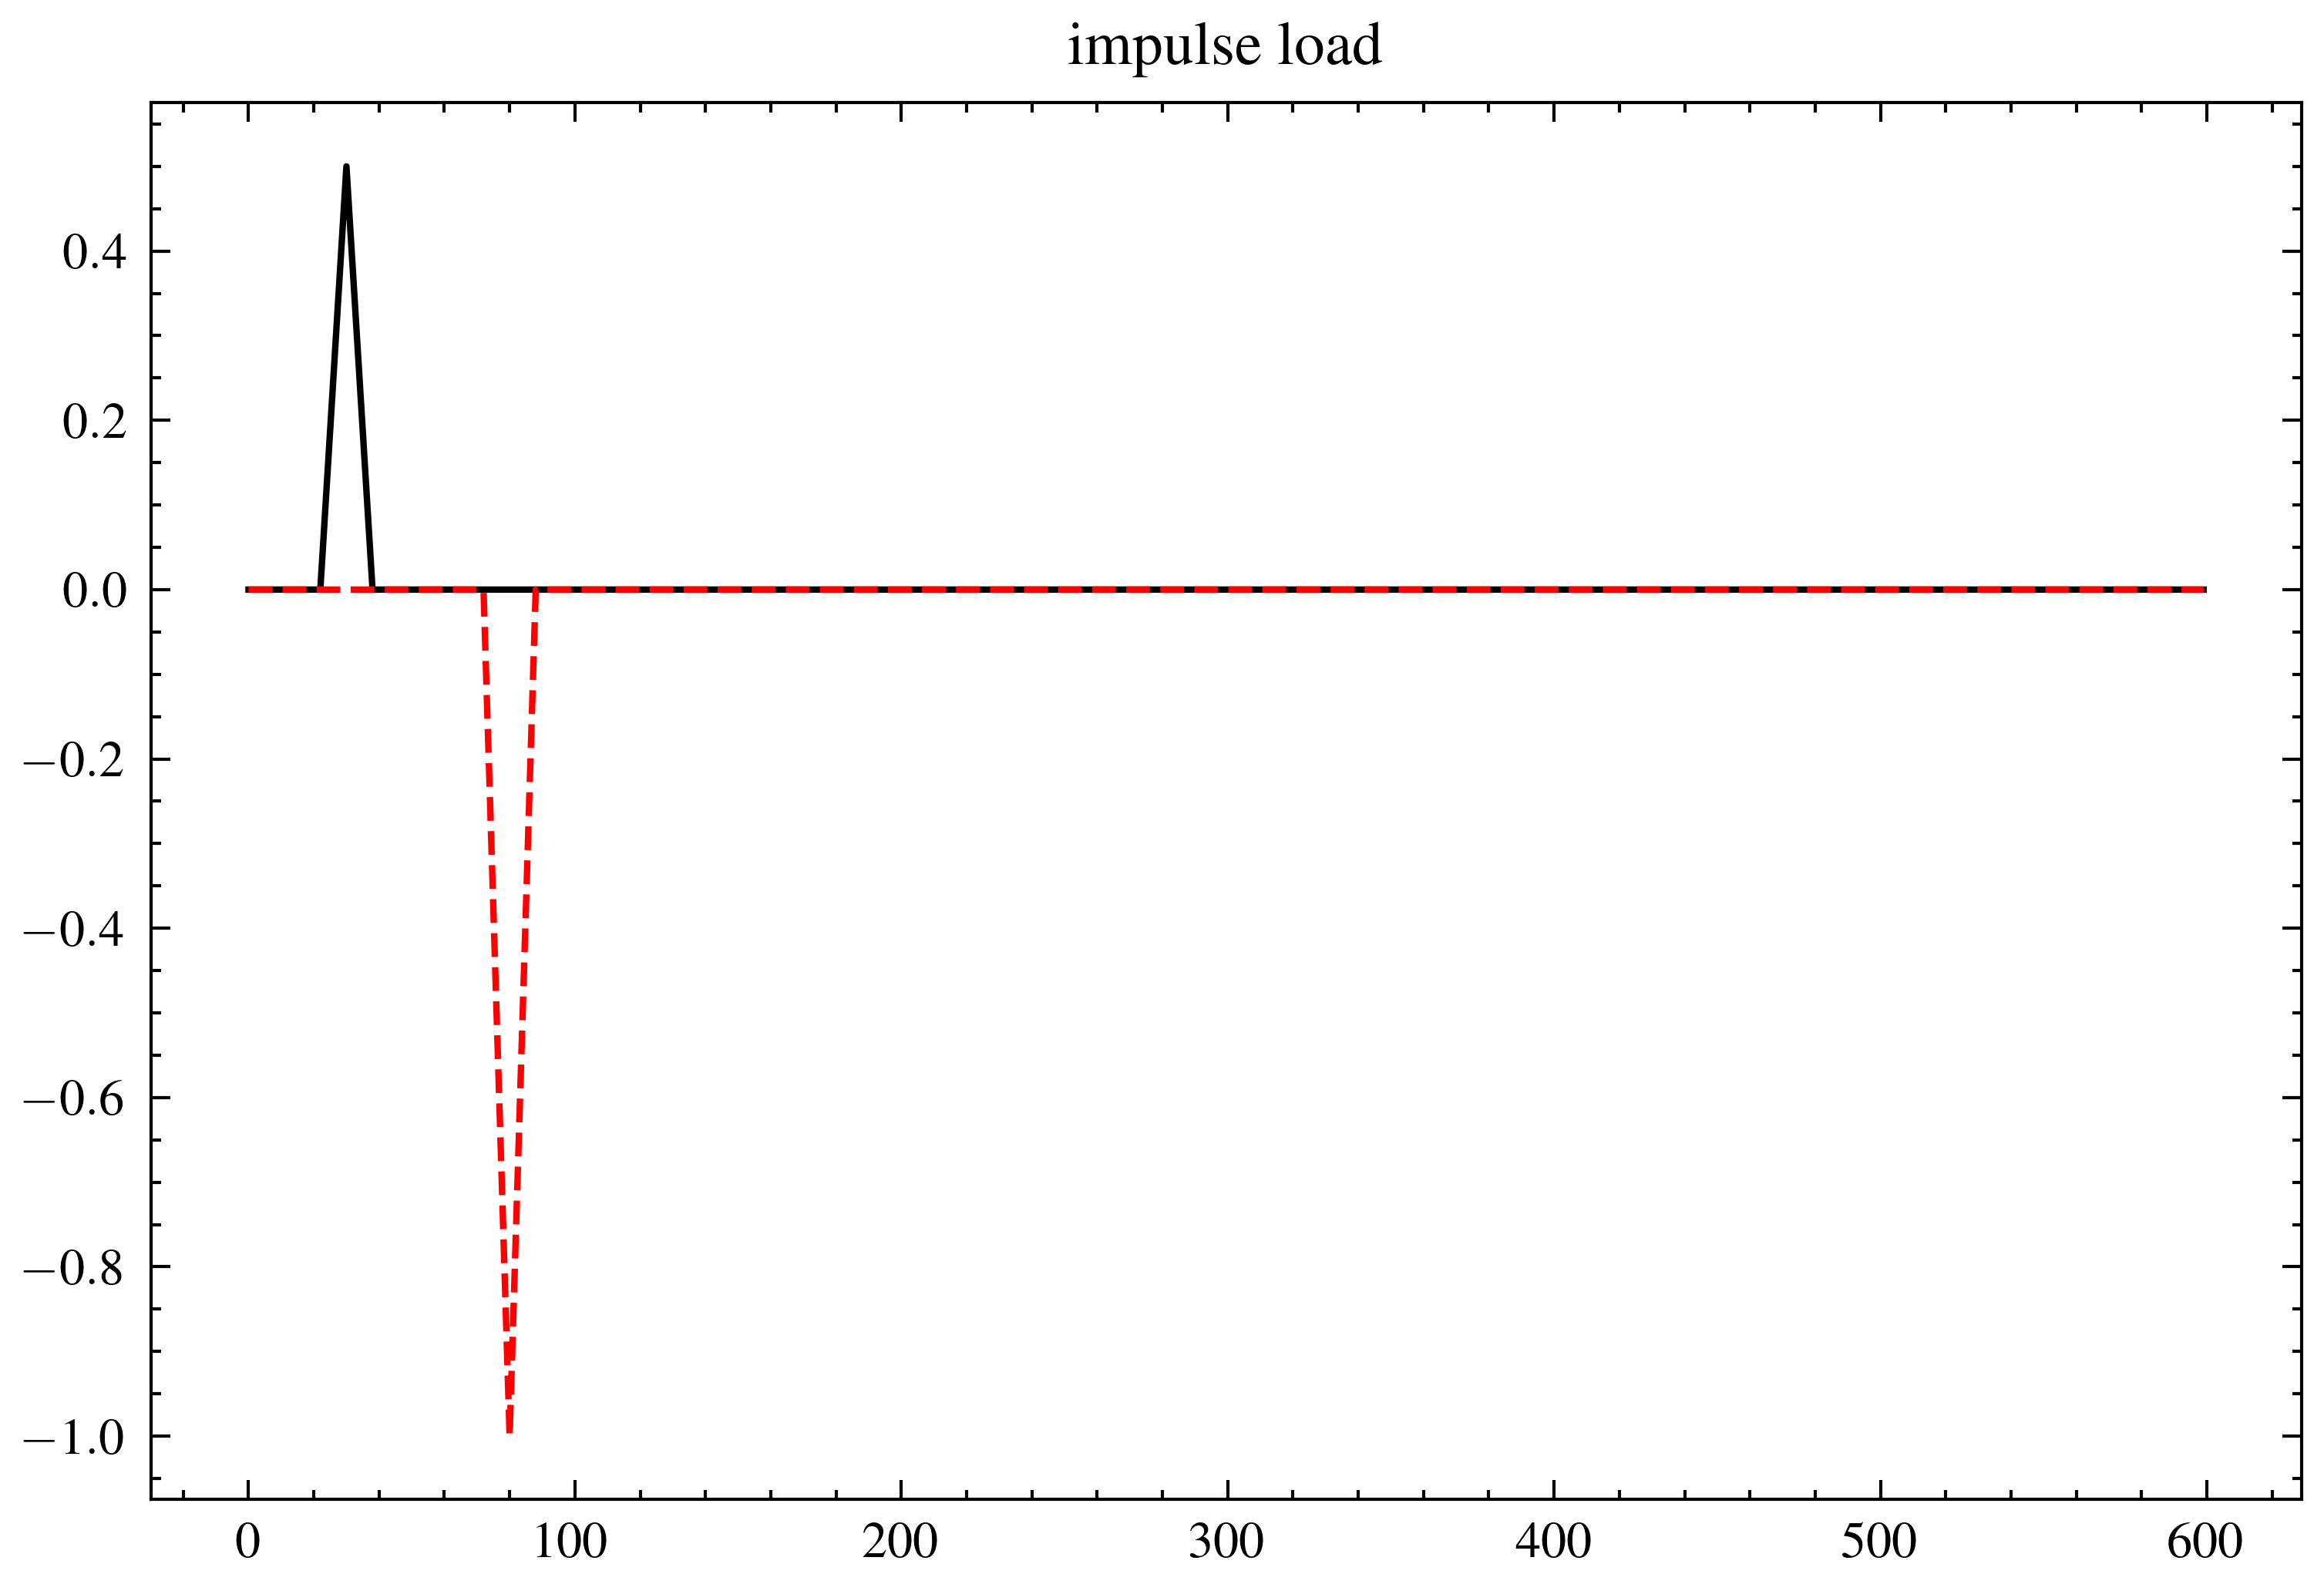

In [18]:
plt.plot(impulse_ex)
plt.title('impulse load')
plt.show()

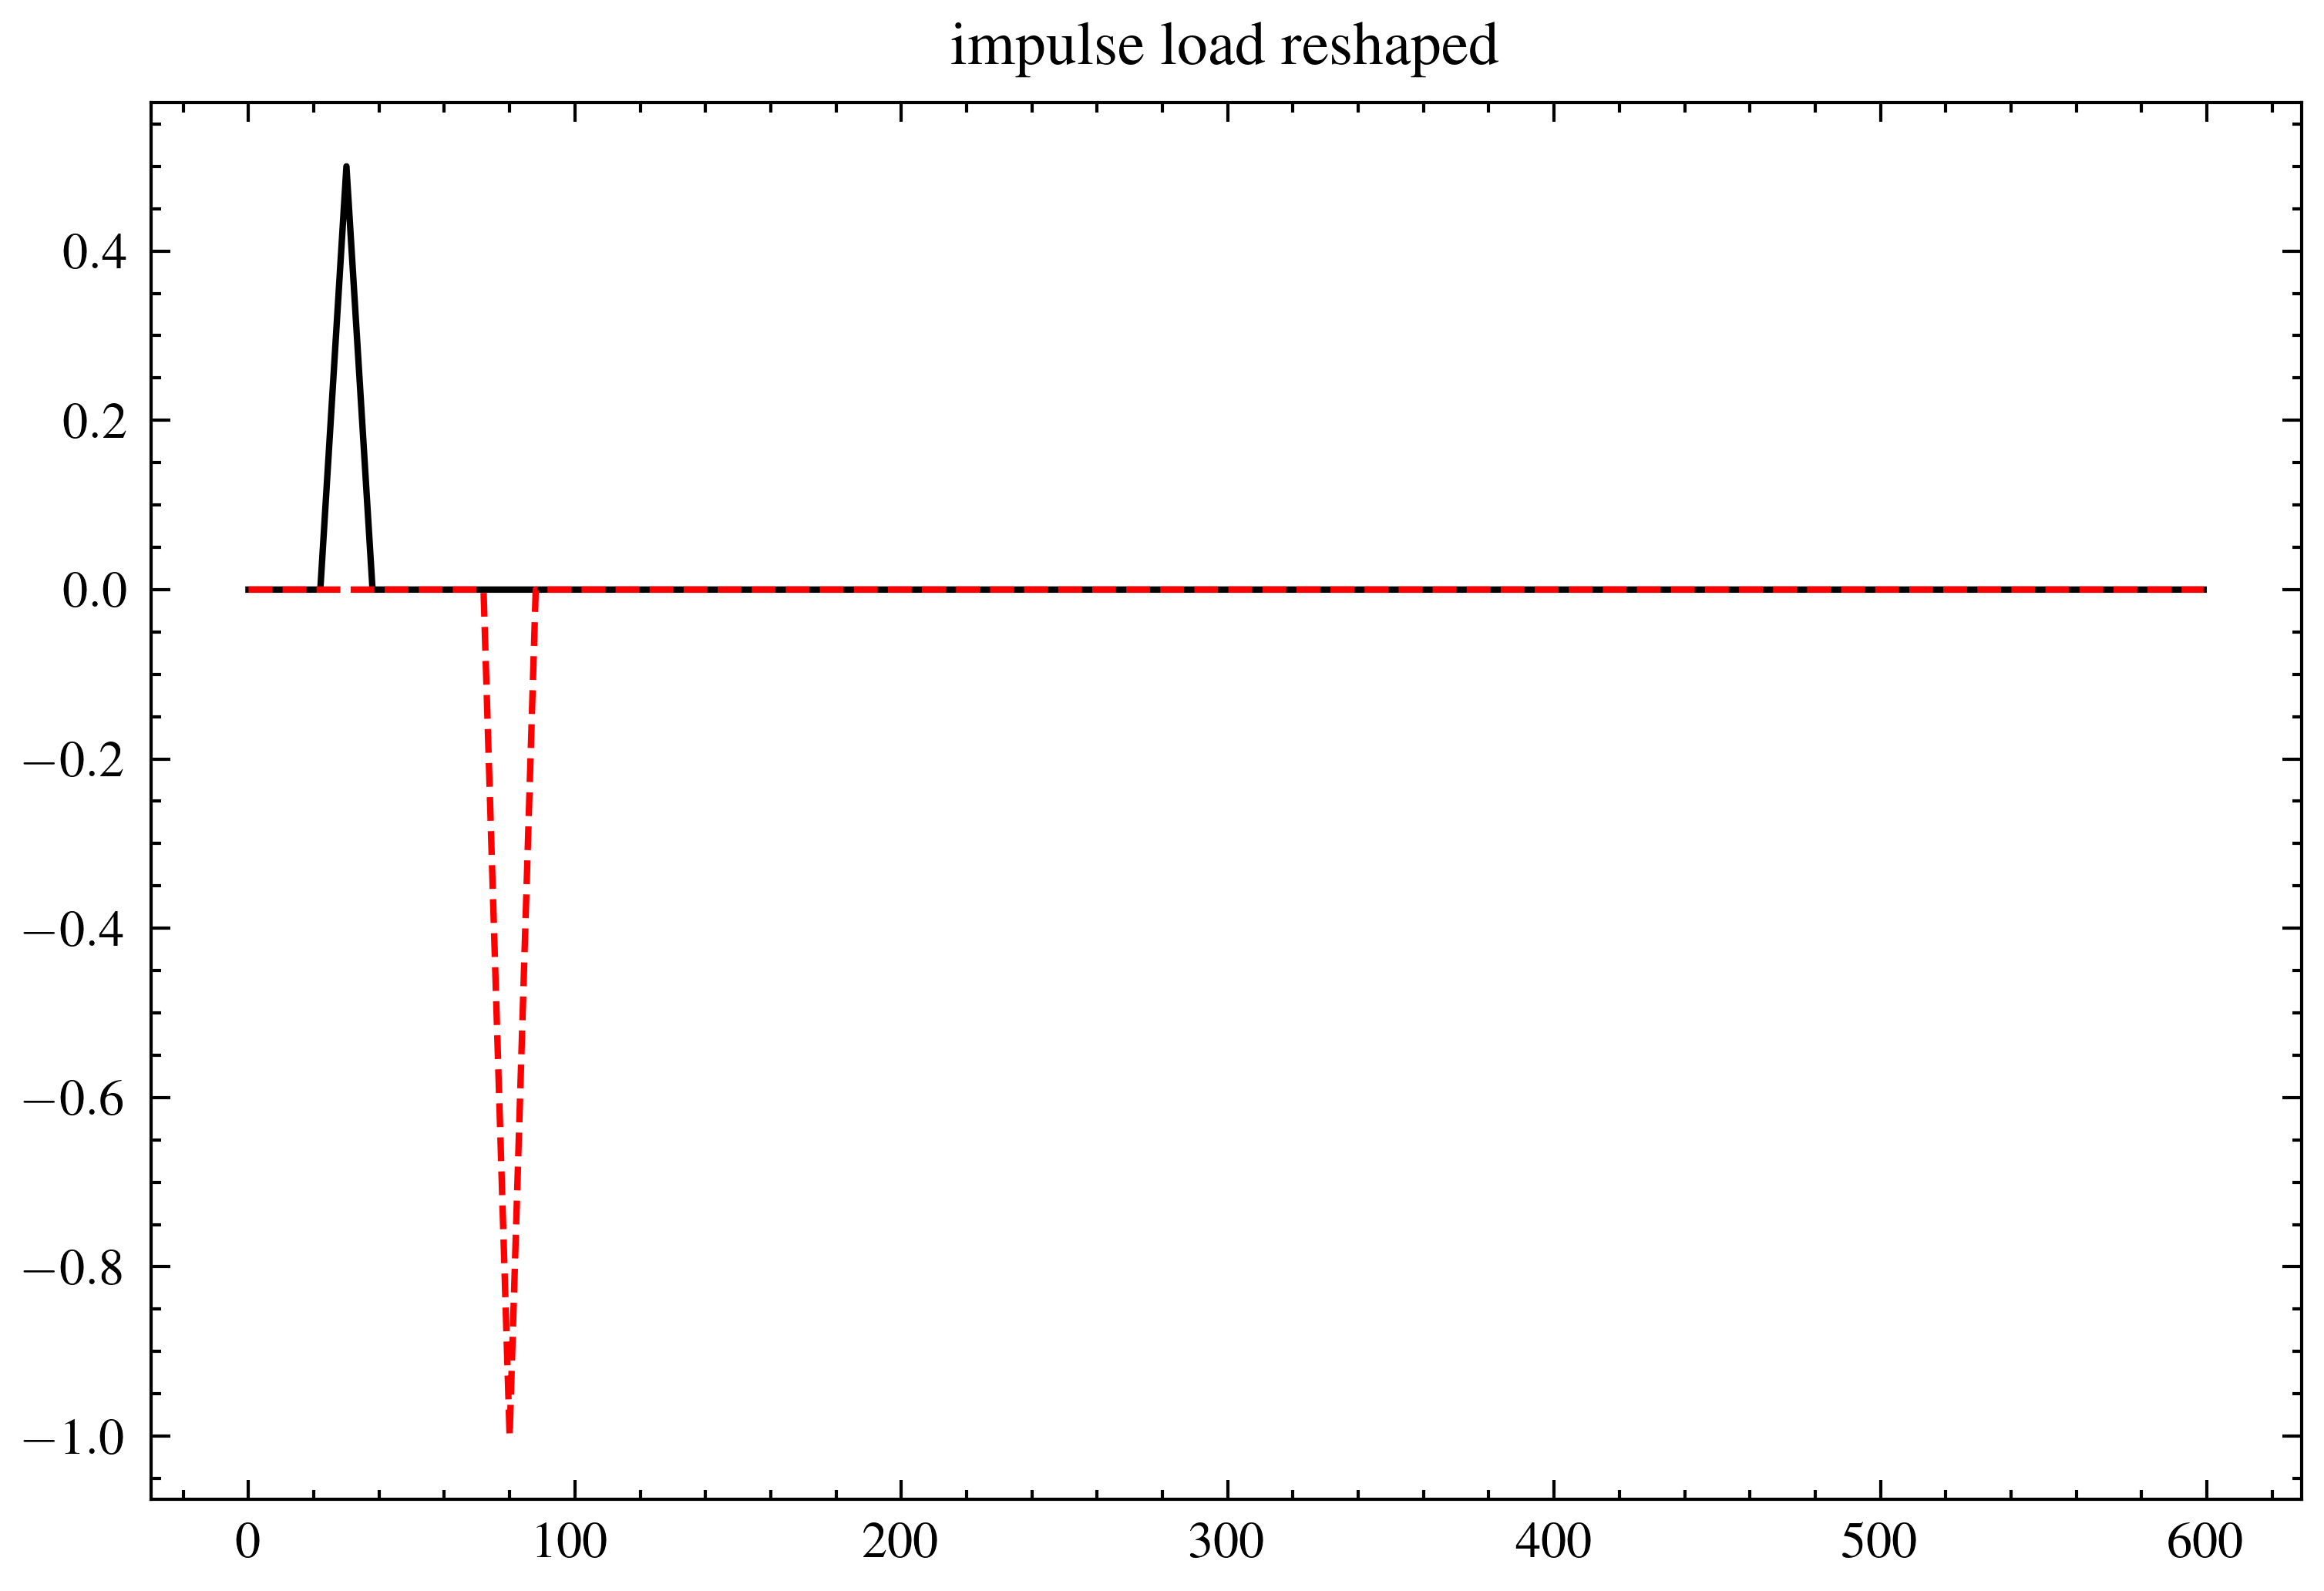

In [19]:
plt.plot(impulse_ex_reshaped[::2])
plt.plot(impulse_ex_reshaped[1::2])
plt.title('impulse load reshaped')
plt.show()

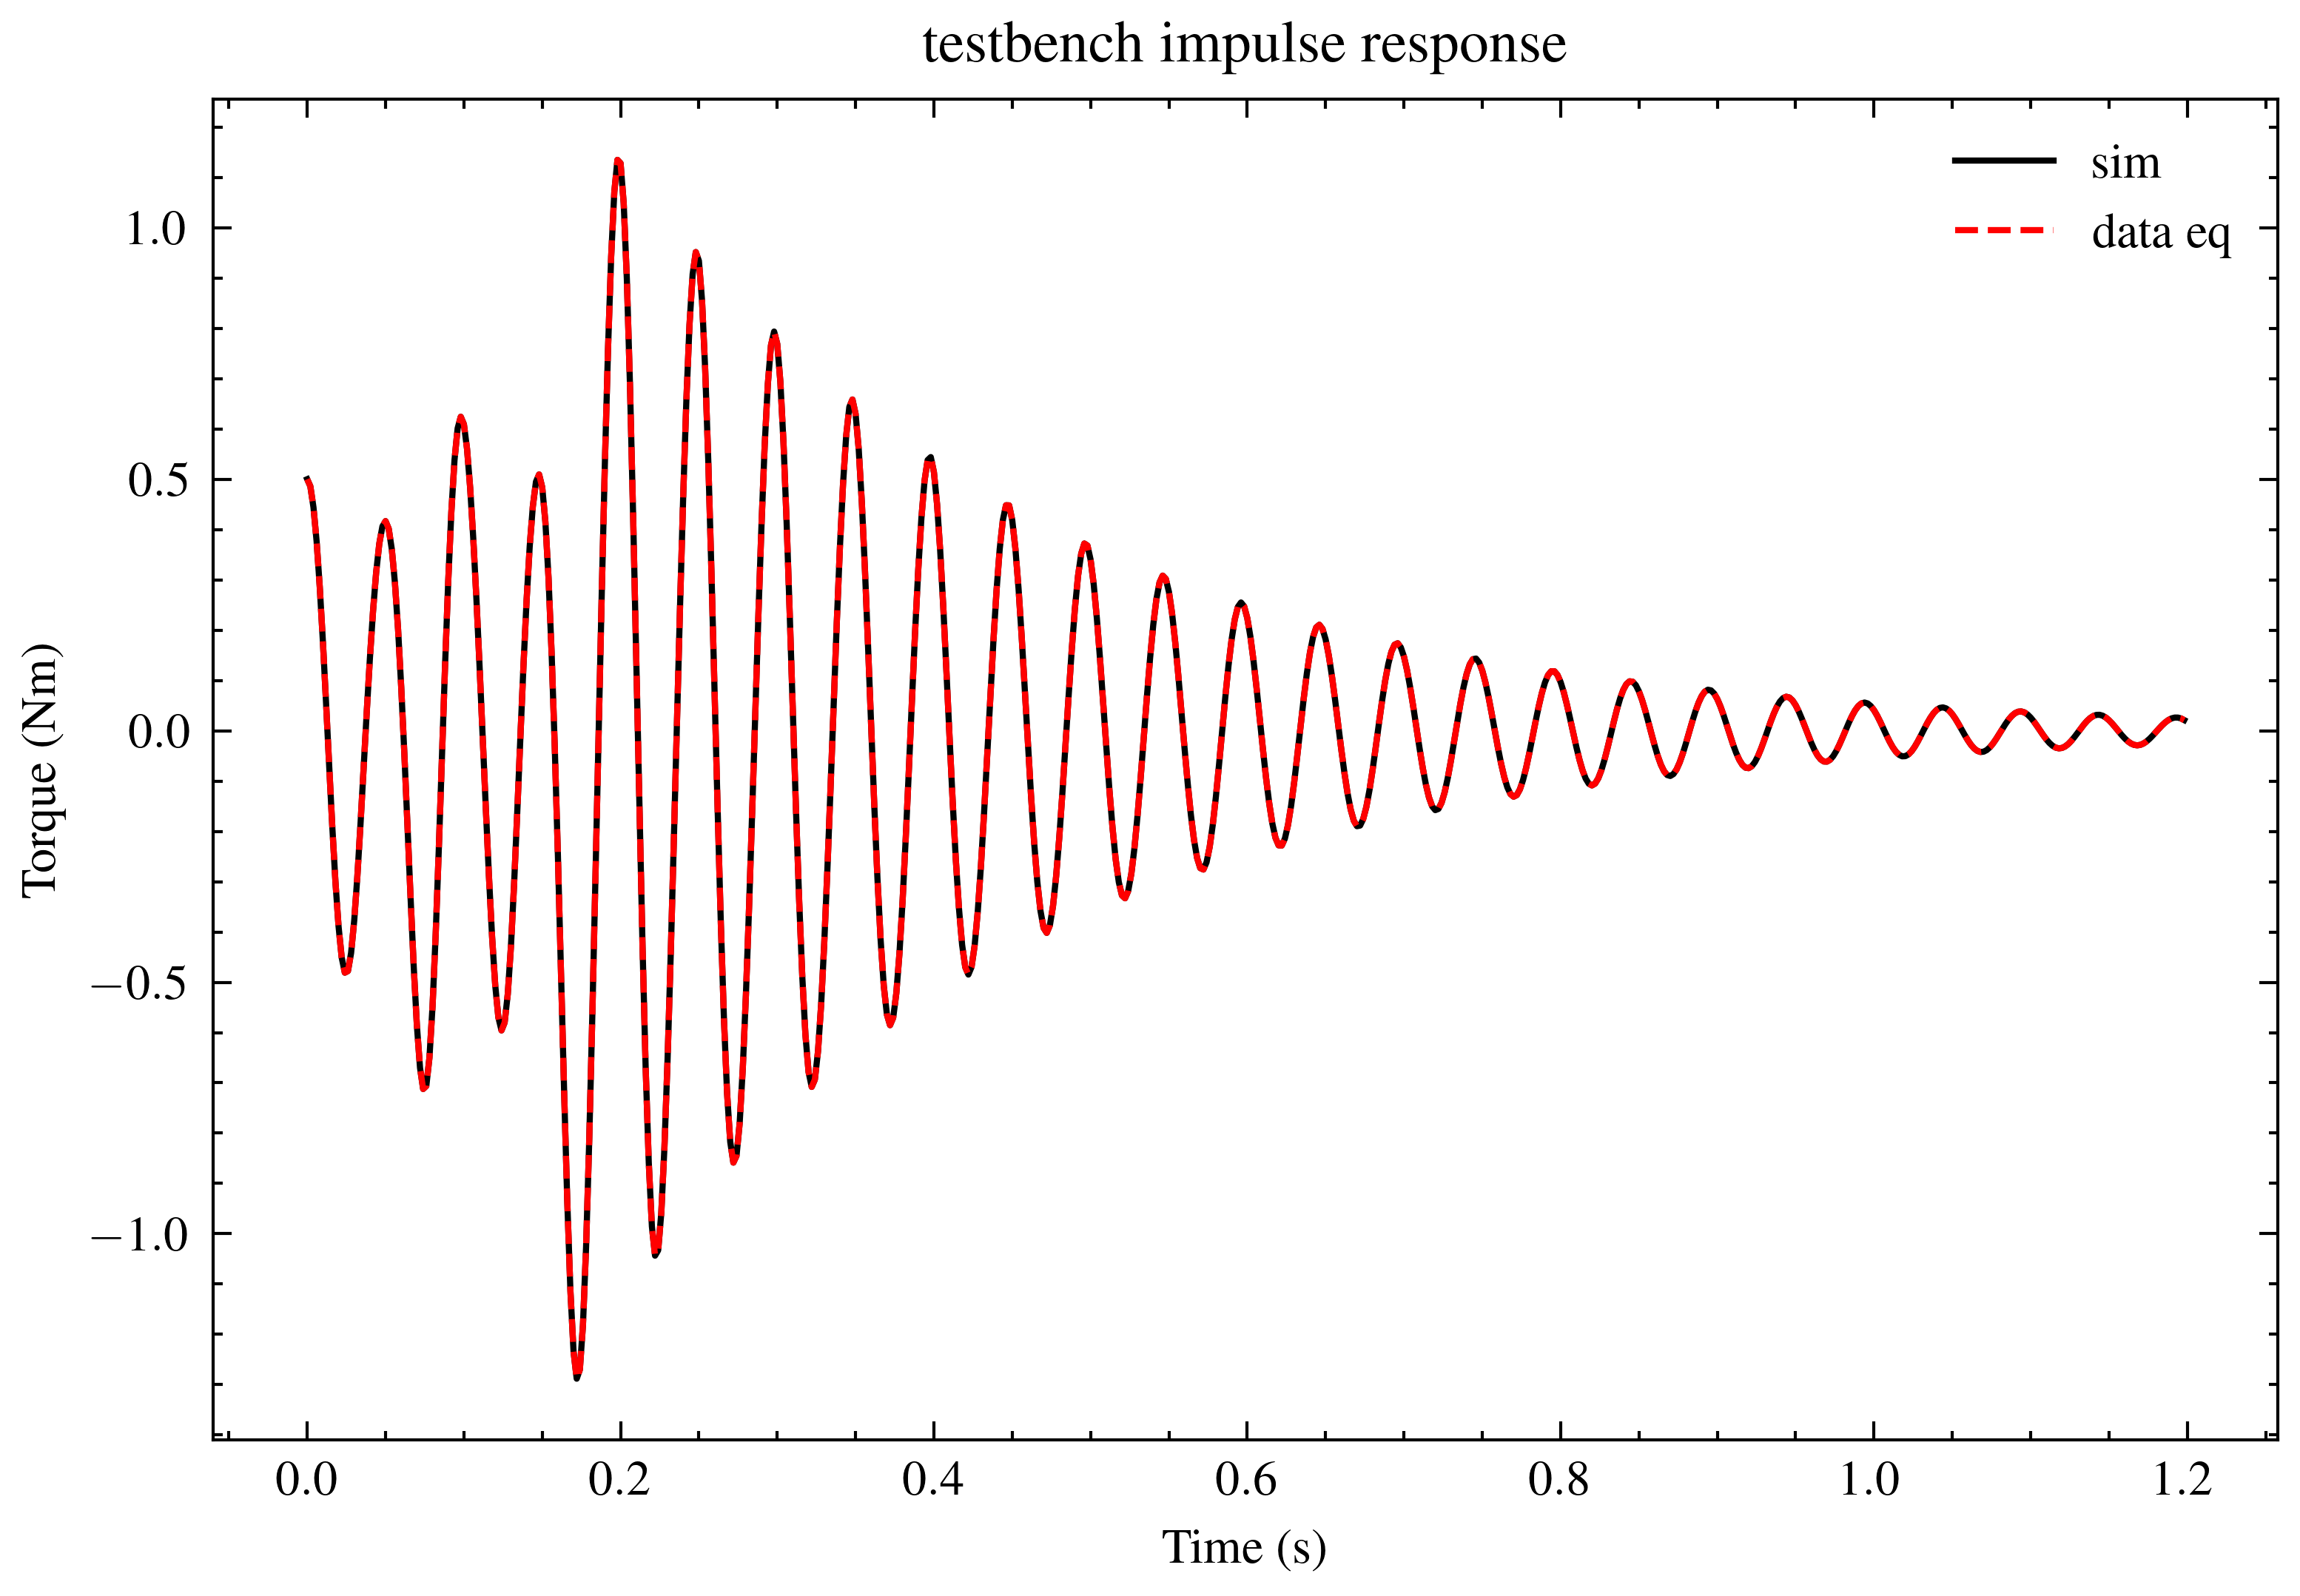

In [20]:
plt.plot(t, dyout_imp[:,0], label='sim')
plt.plot(t, meases[0,:], label='data eq')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('testbench impulse response')
plt.show()

In [21]:
L_ = L(m*N) # identity matrix
D_ = second_difference_matrix(N, m)

R_ = 1e-4*np.eye(C.shape[0]) # measurement covariance, shape (n_sensors, n_sensors)
r = np.random.multivariate_normal(np.zeros(R_.shape[0]), R_, t.shape[0])
#r = np.random.normal(0, .01, t.shape[0])
e = np.reshape(r.T, (-1,1))

Y = np.reshape(dyout_imp, (-1,1))
noisy_meas = Y + 0.1*e

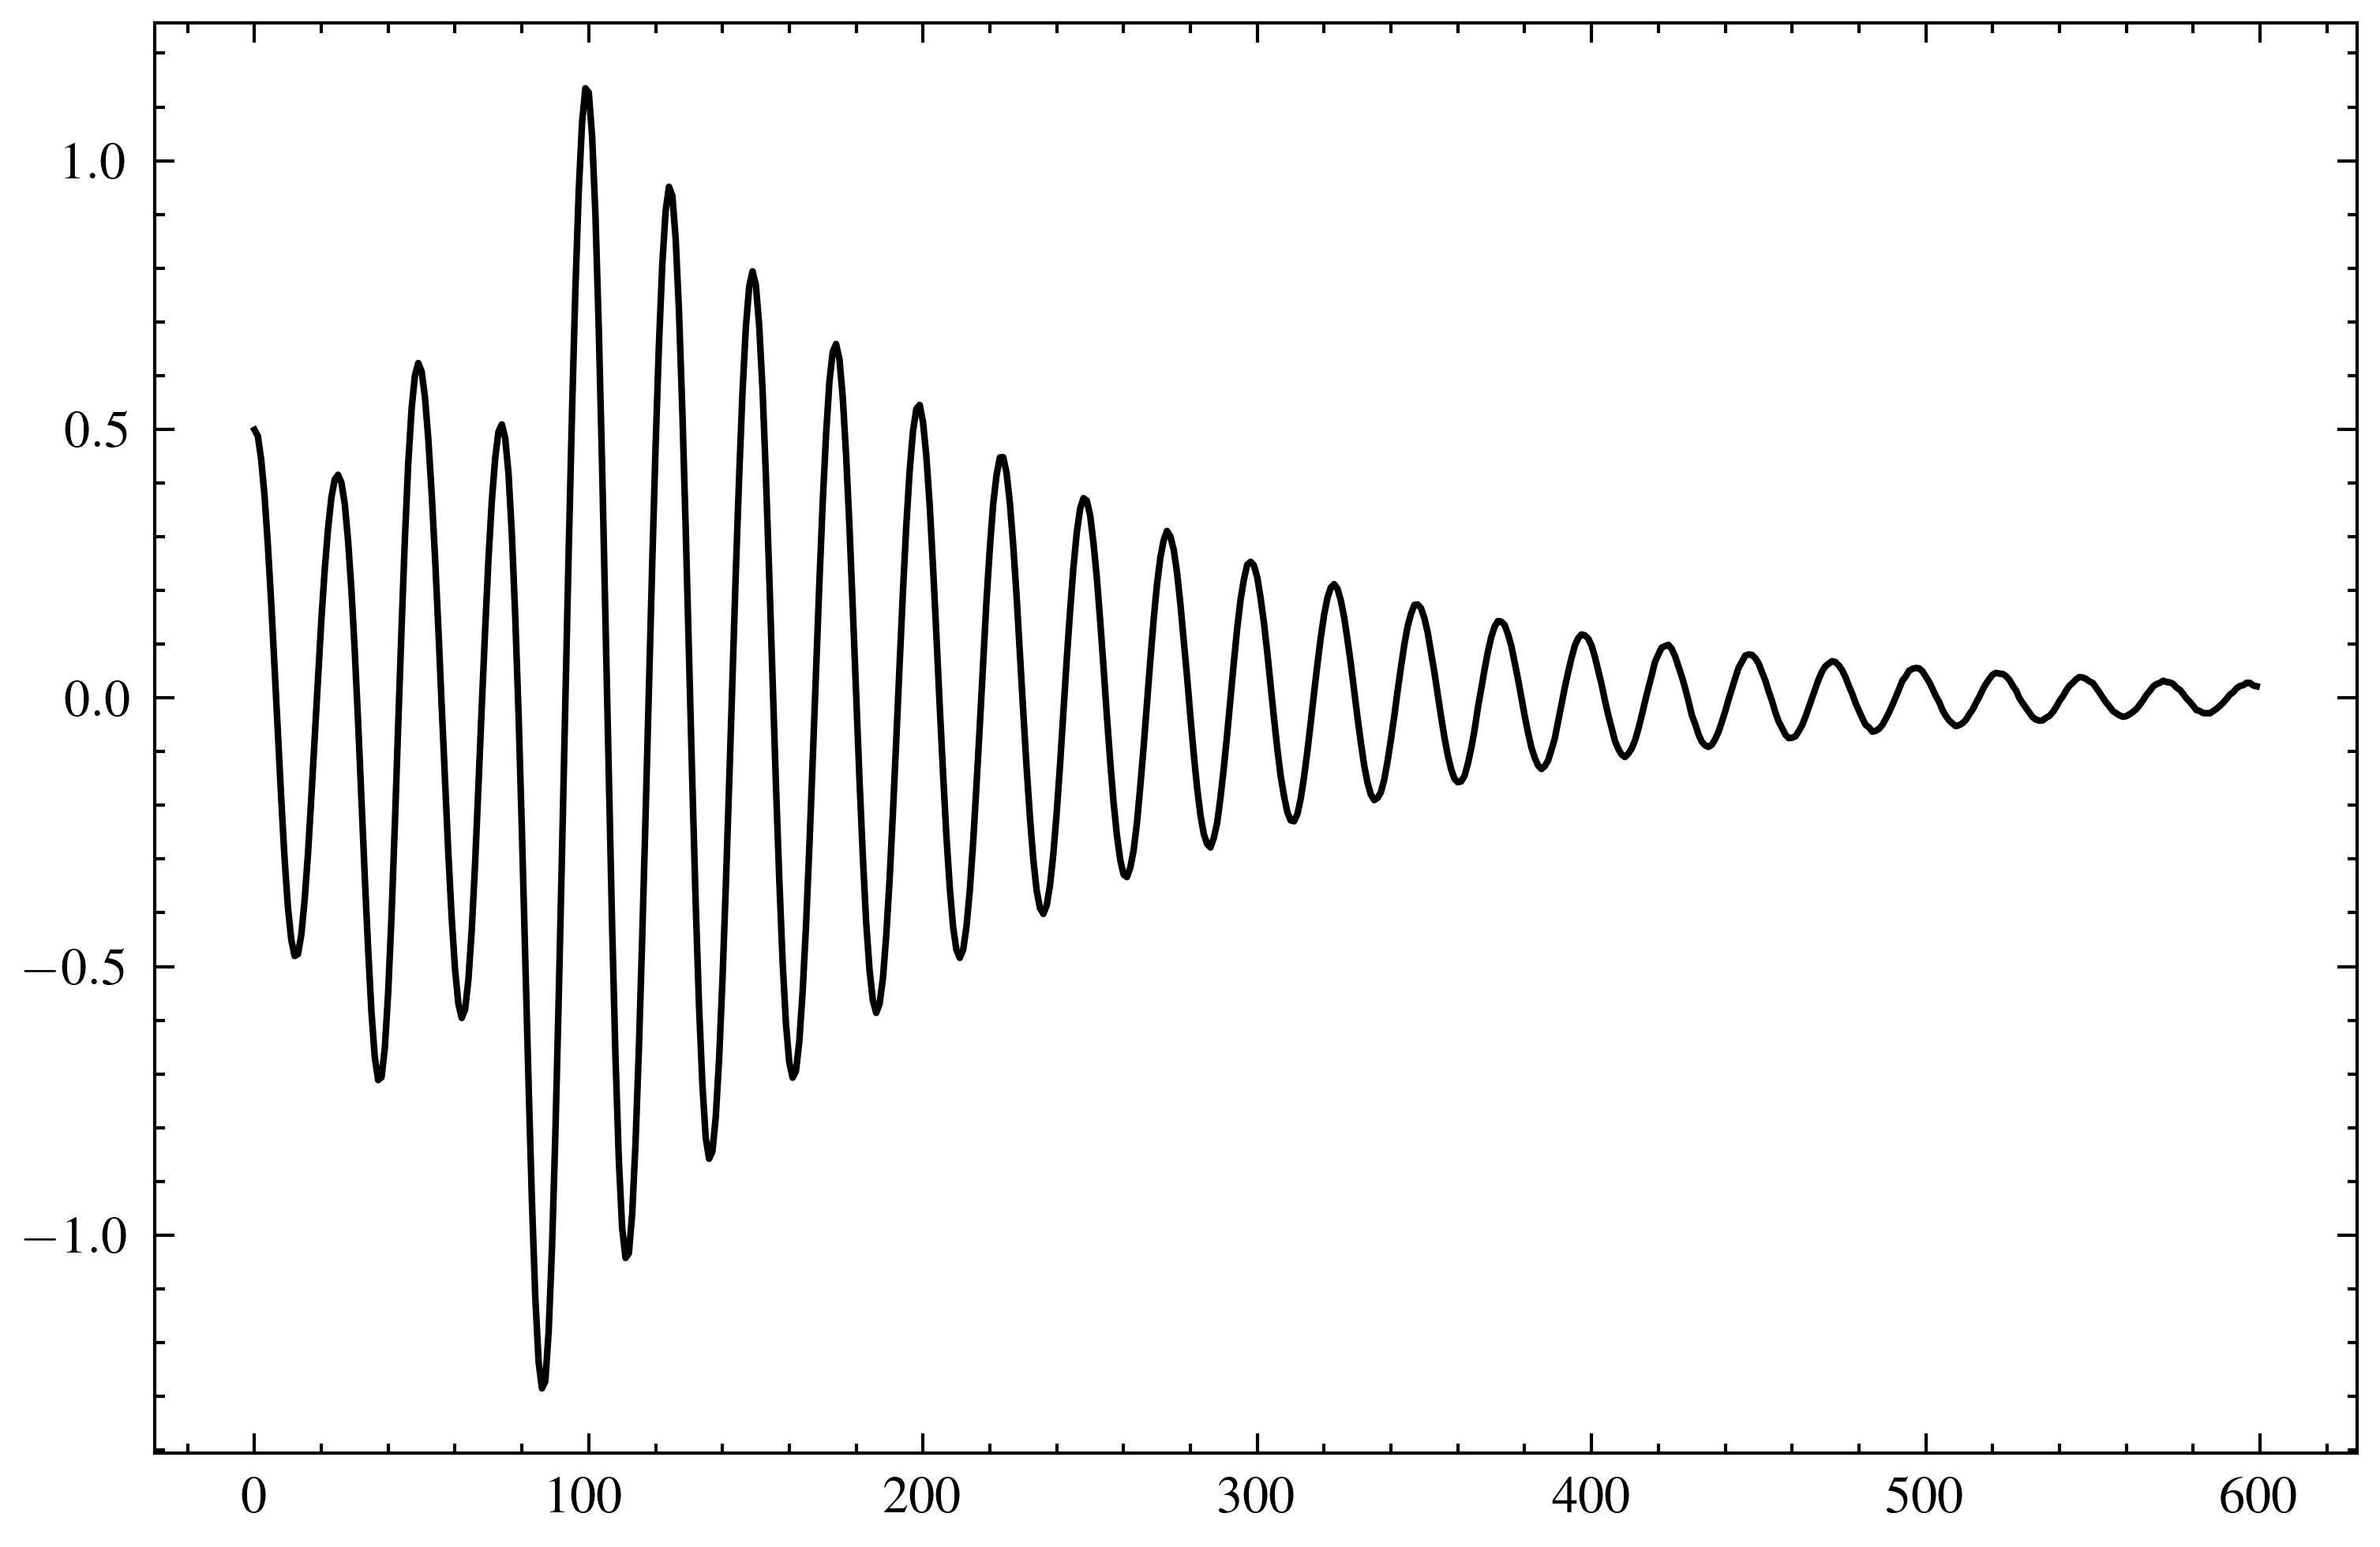

In [22]:
plt.plot(noisy_meas[::C.shape[0]])
plt.show()

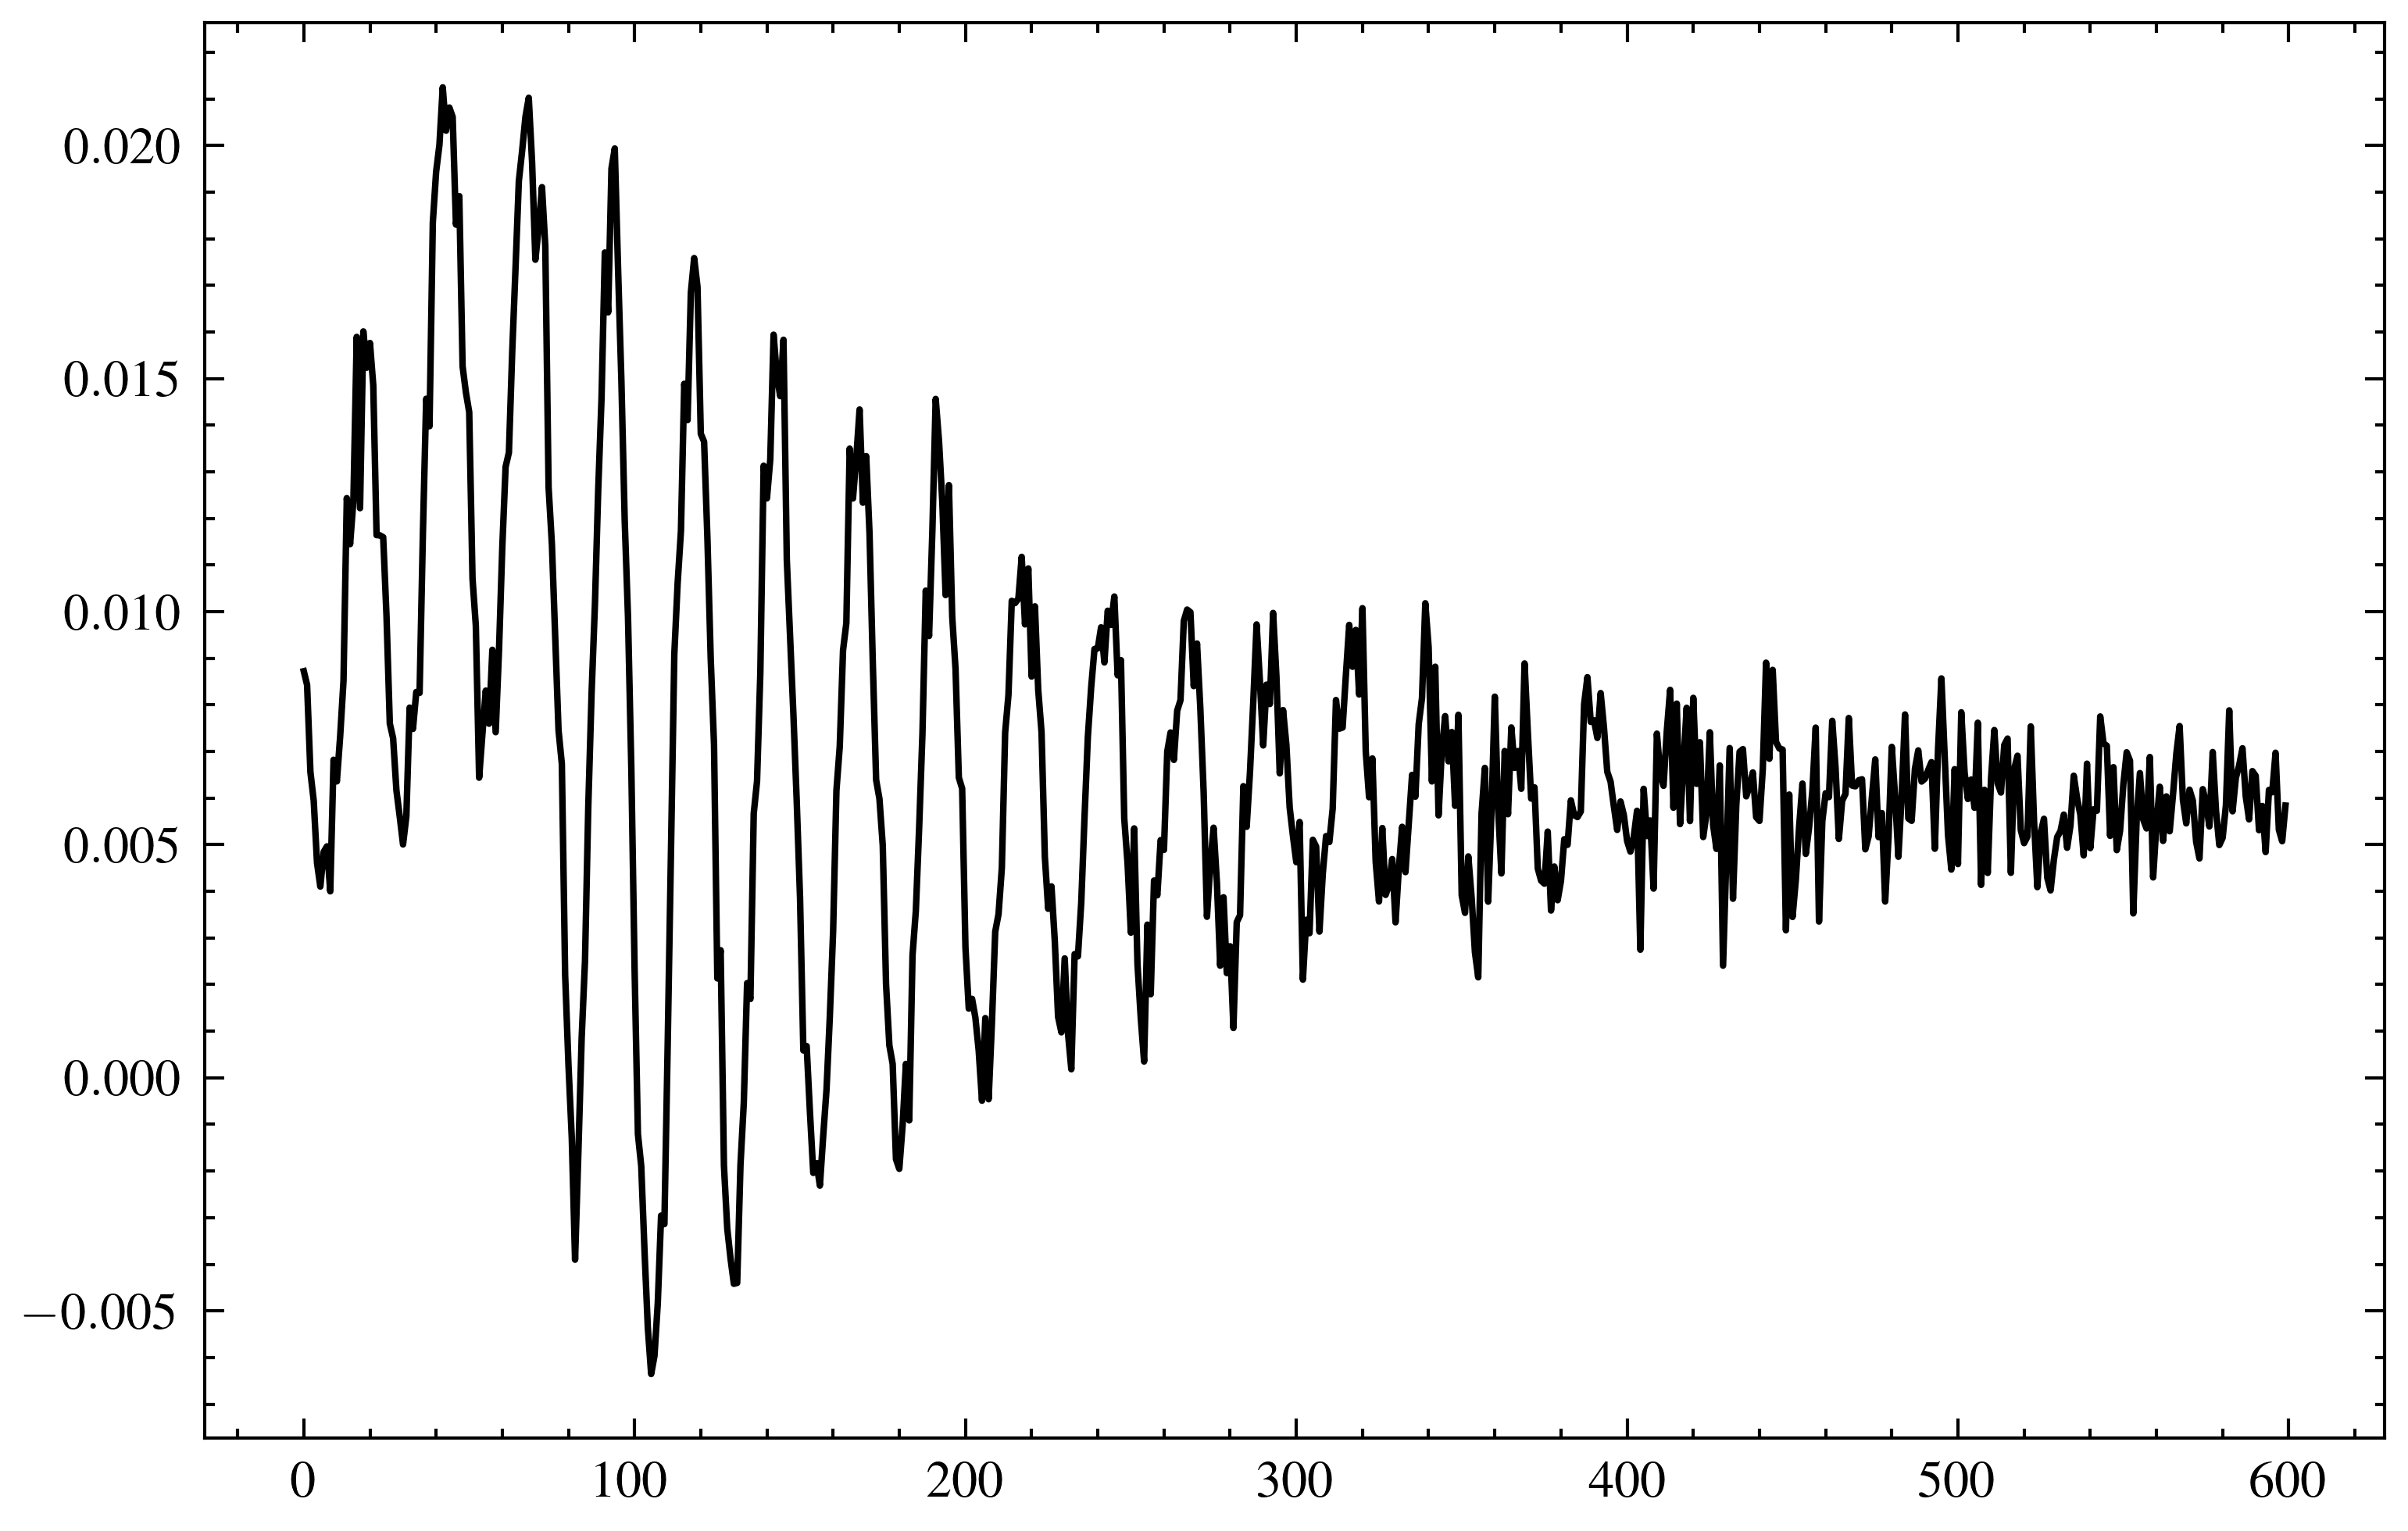

In [23]:
plt.plot(noisy_meas[1::C.shape[0]])

In [24]:
u_hat, x_hat = tikhonov_problem(noisy_meas, O_, G, L_, lam=0.01)
u_hat_l, x_hat_l = lasso_problem(noisy_meas, O_, G, L_, lam=0.01)

In [25]:
print('Initial state estimate (Tikhonov):\n', x_hat)
print('Initial state estimate (LASSO):\n', x_hat_l)

Initial state estimate (Tikhonov):
 [[0.50376571]
 [0.50004524]
 [0.0113022 ]
 [0.01122504]
 [0.01121672]]
Initial state estimate (LASSO):
 [[0.50009992]
 [0.50227997]
 [0.01364812]
 [0.01370366]
 [0.01361752]]


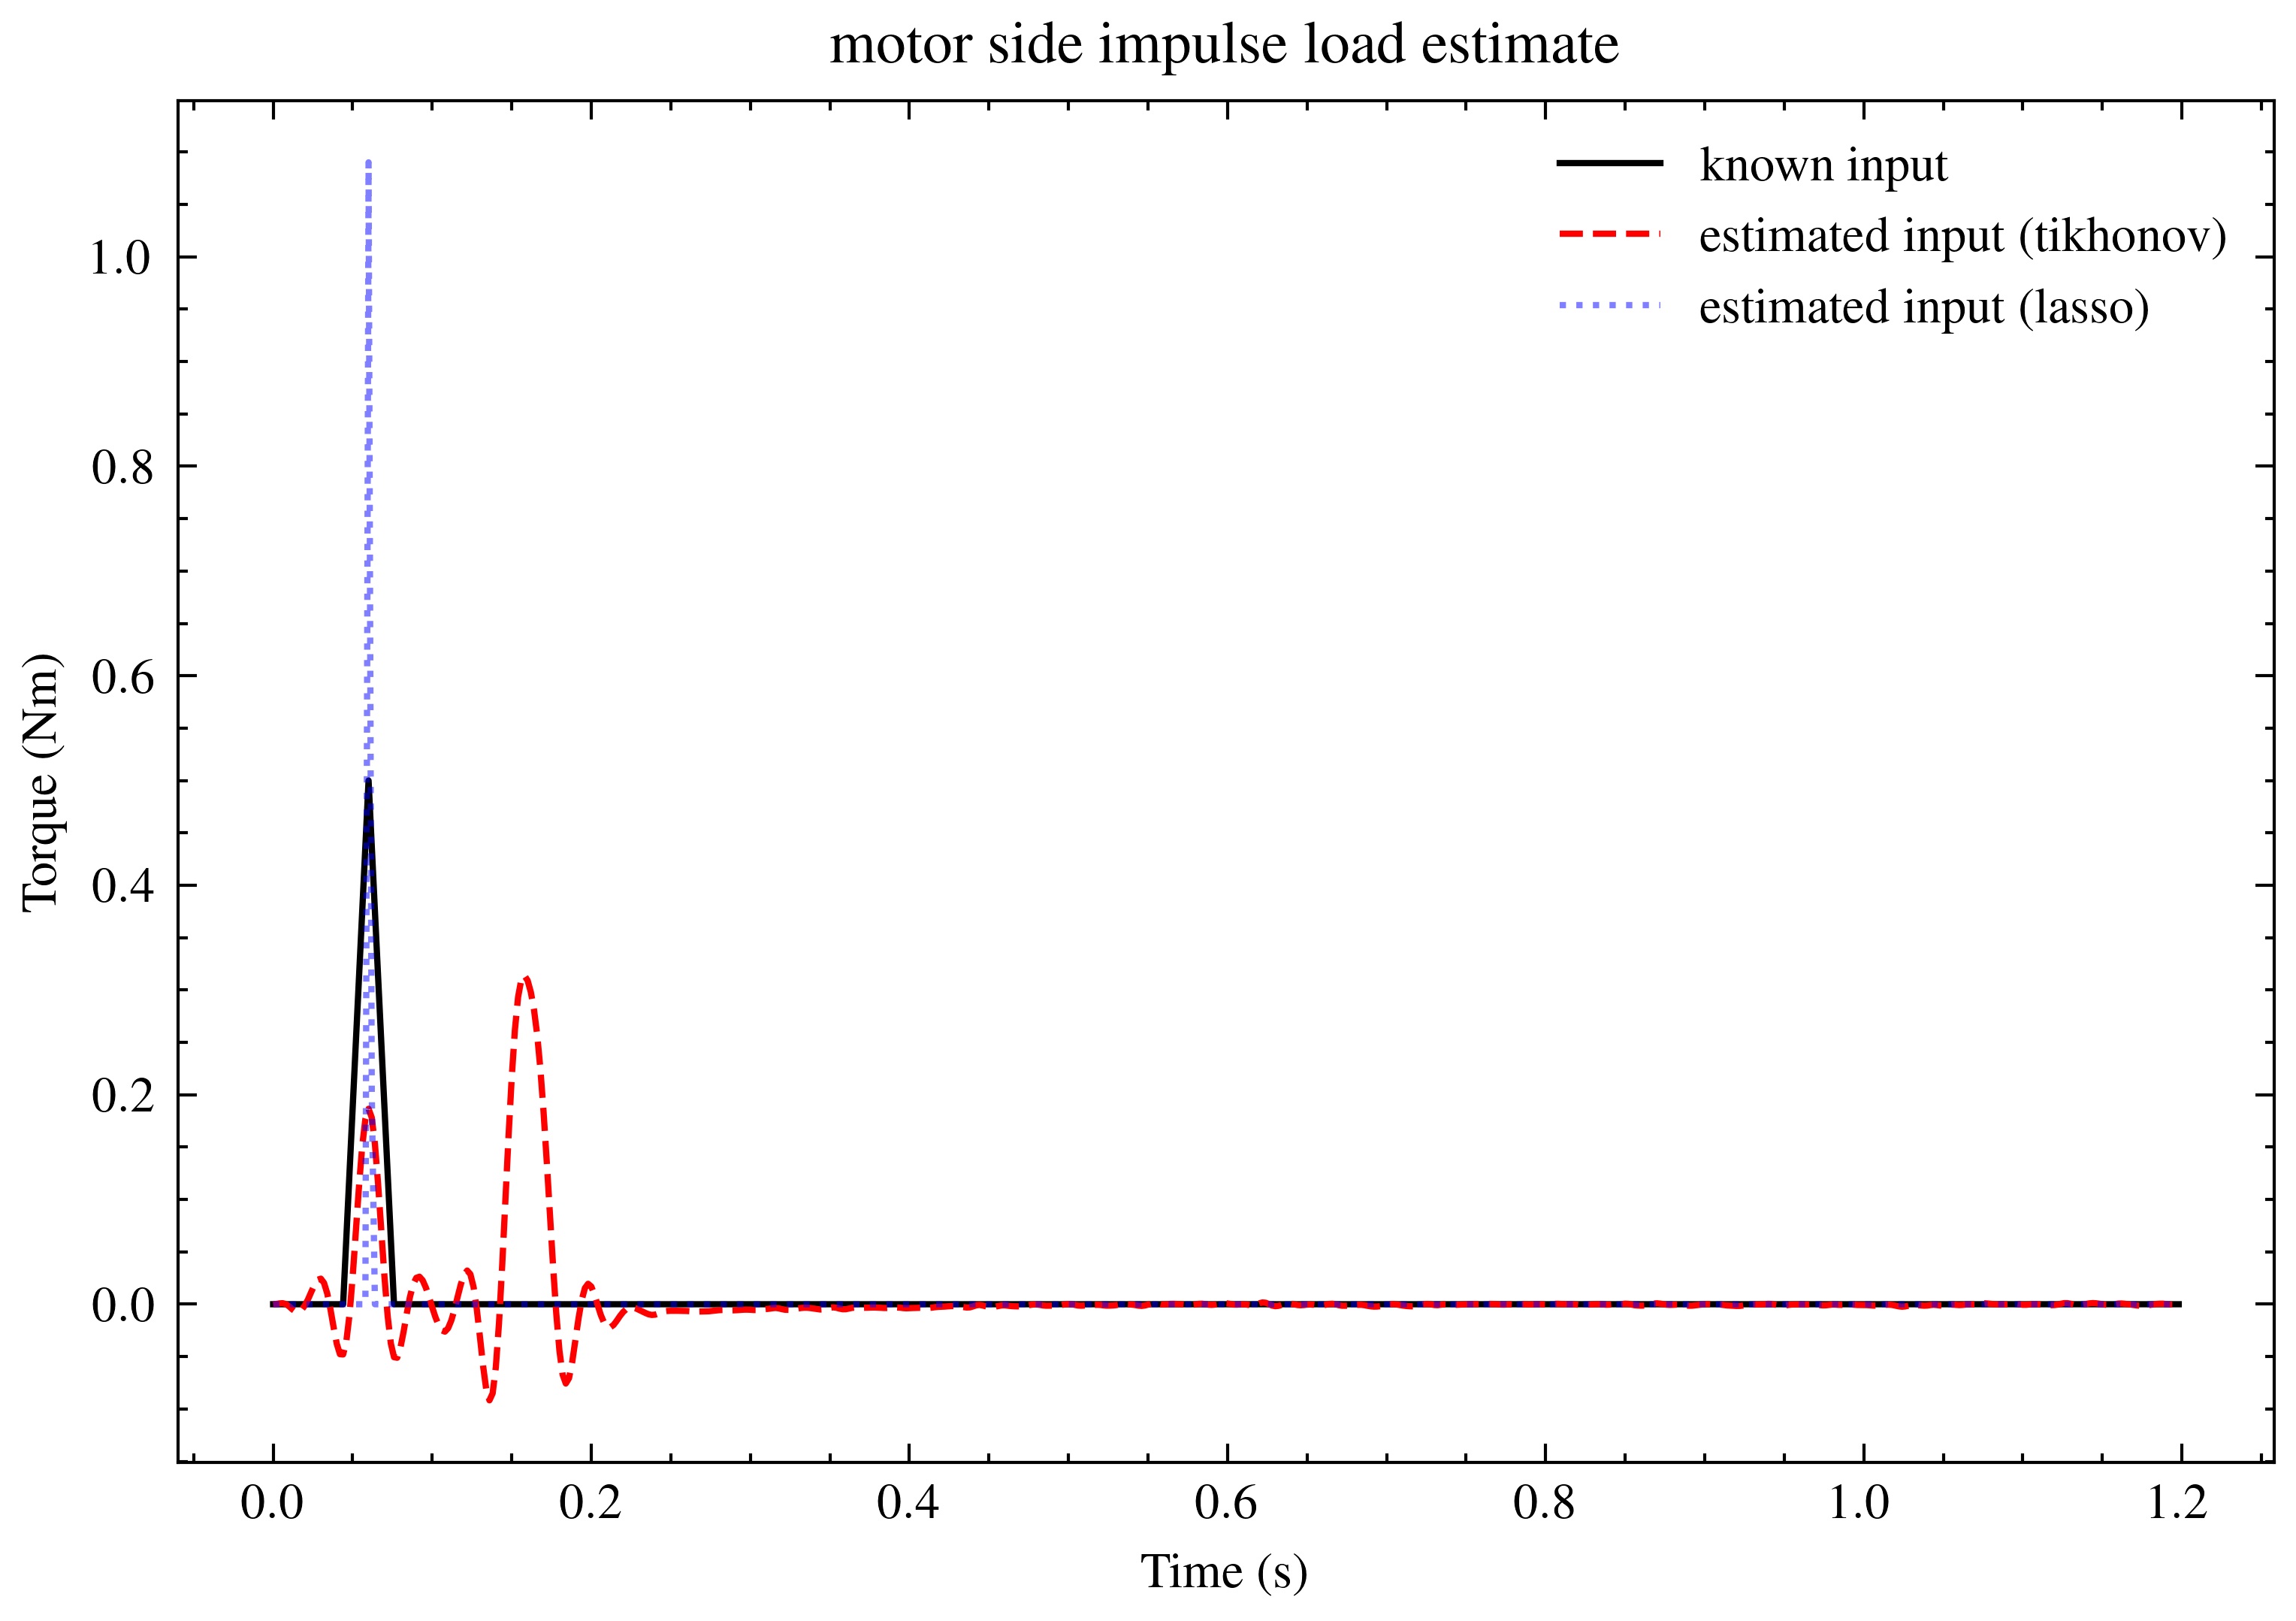

In [26]:
plt.plot(t, impulse_ex_reshaped[::2], label='known input')
plt.plot(t, u_hat[::2], label='estimated input (tikhonov)')
plt.plot(t, u_hat_l[::2], label='estimated input (lasso)', alpha=0.5)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('motor side impulse load estimate')
plt.show()

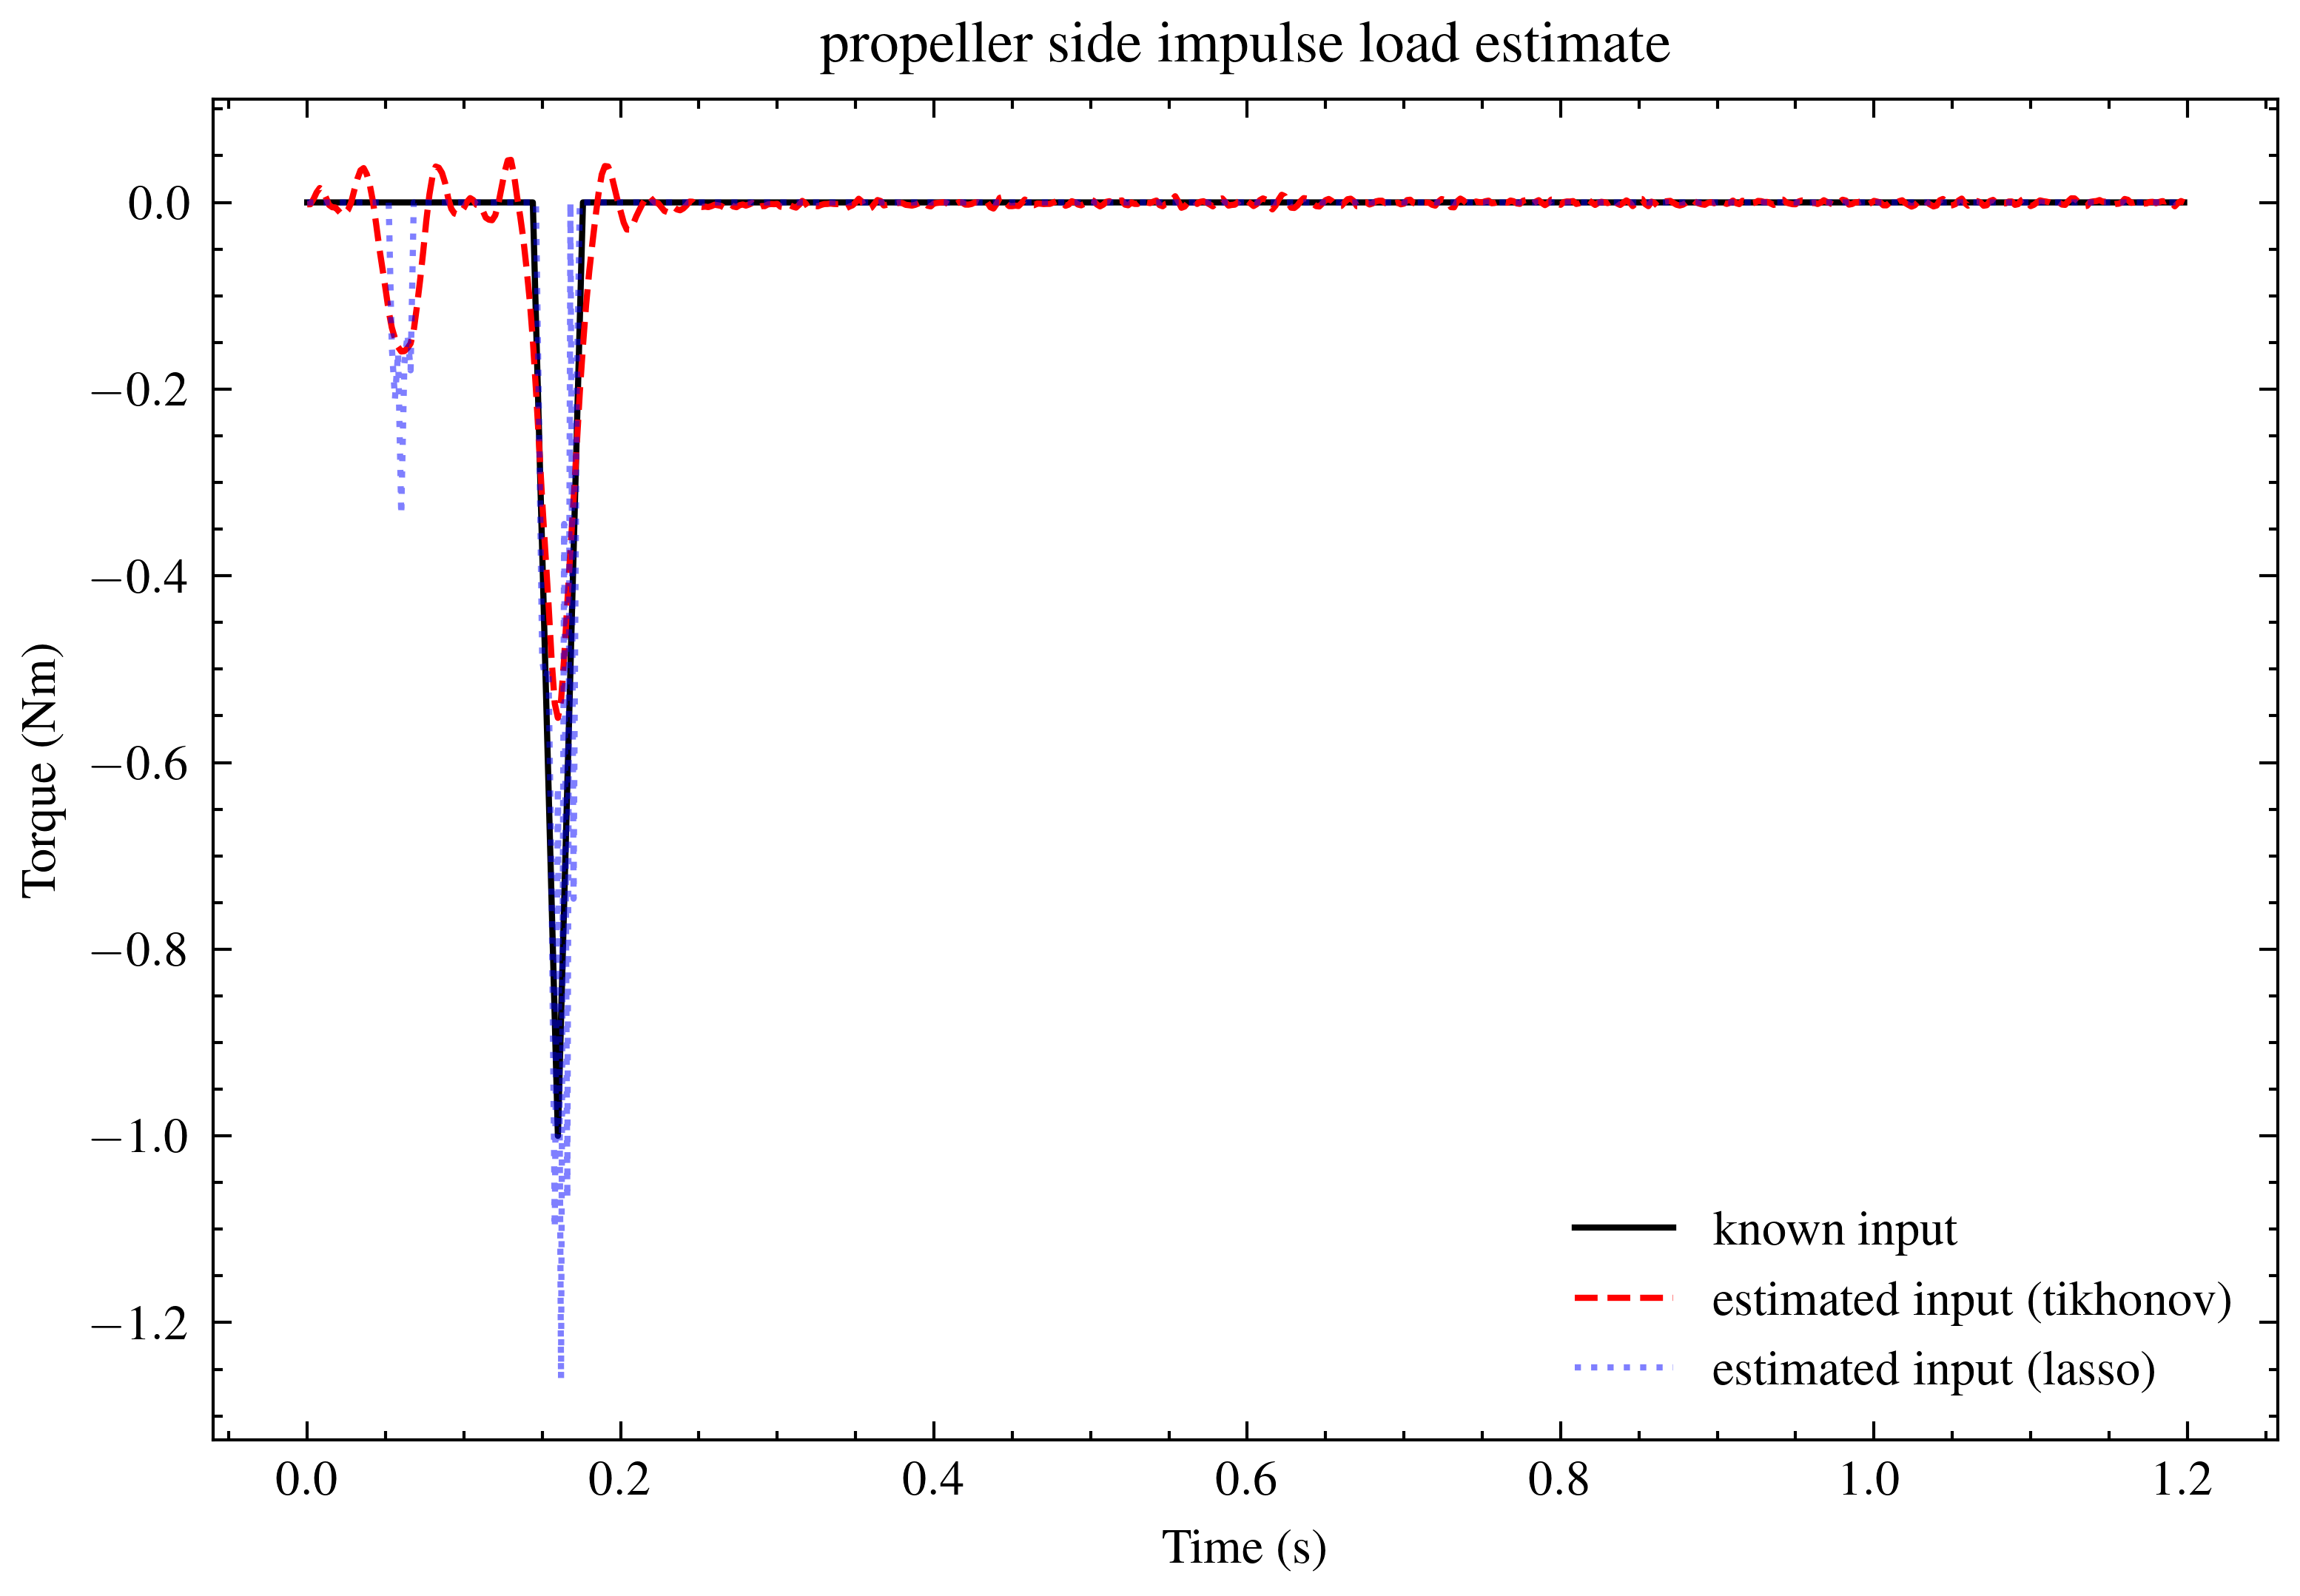

In [27]:
plt.plot(t, impulse_ex_reshaped[1::2], label='known input')
plt.plot(t, u_hat[1::2], label='estimated input (tikhonov)')
plt.plot(t, u_hat_l[1::2], label='estimated input (lasso)', alpha=0.5)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('propeller side impulse load estimate')
plt.show()

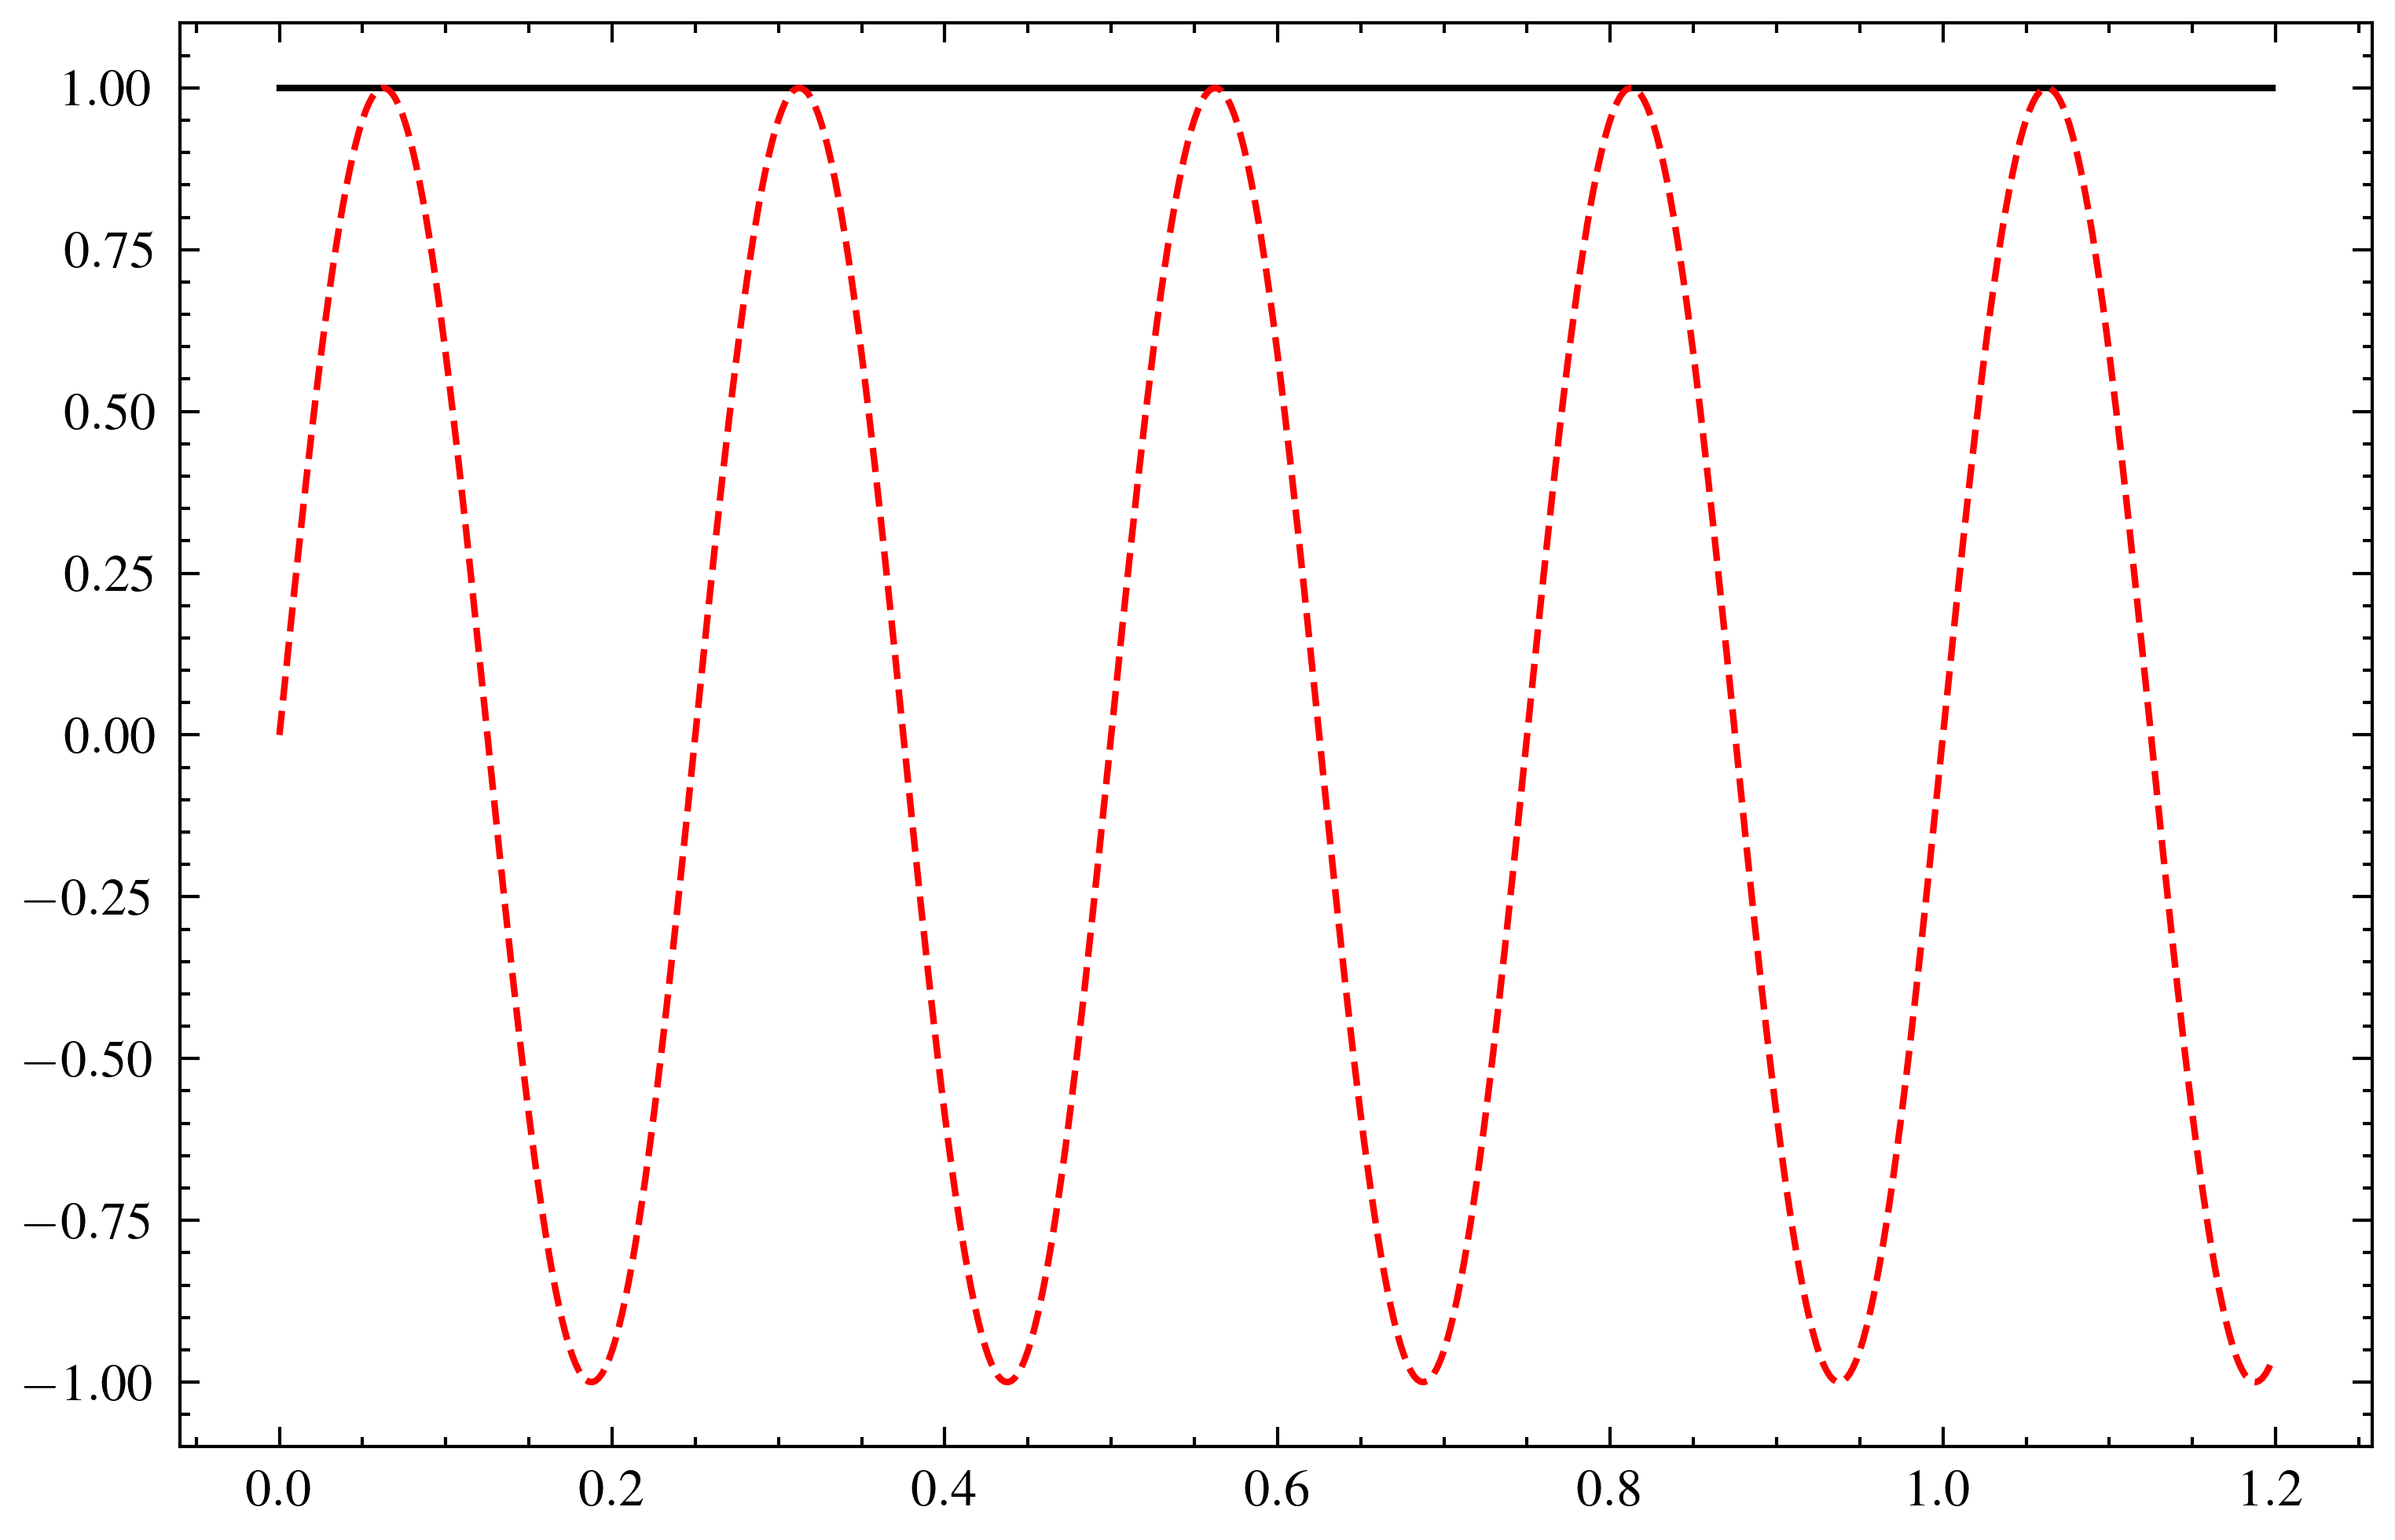

In [28]:
sin_ex = np.zeros((len(t), 2))
sin_ex[:,0] += 1
sin_ex[:,1] += np.sin(4*2*np.pi*t)

plt.plot(t, sin_ex)
plt.show()

In [29]:
dtout_sin, dyout_sin, dxout_sin = dlsim((A, B, C, D, dt), sin_ex, t=t, x0=x0[:,0])

sin_ex_reshaped = sin_ex.reshape(-1, 1)
y_hat_sin = O_ @ x0 + G @ sin_ex_reshaped
meases_sin = np.hstack(np.vsplit(y_hat_sin, N))

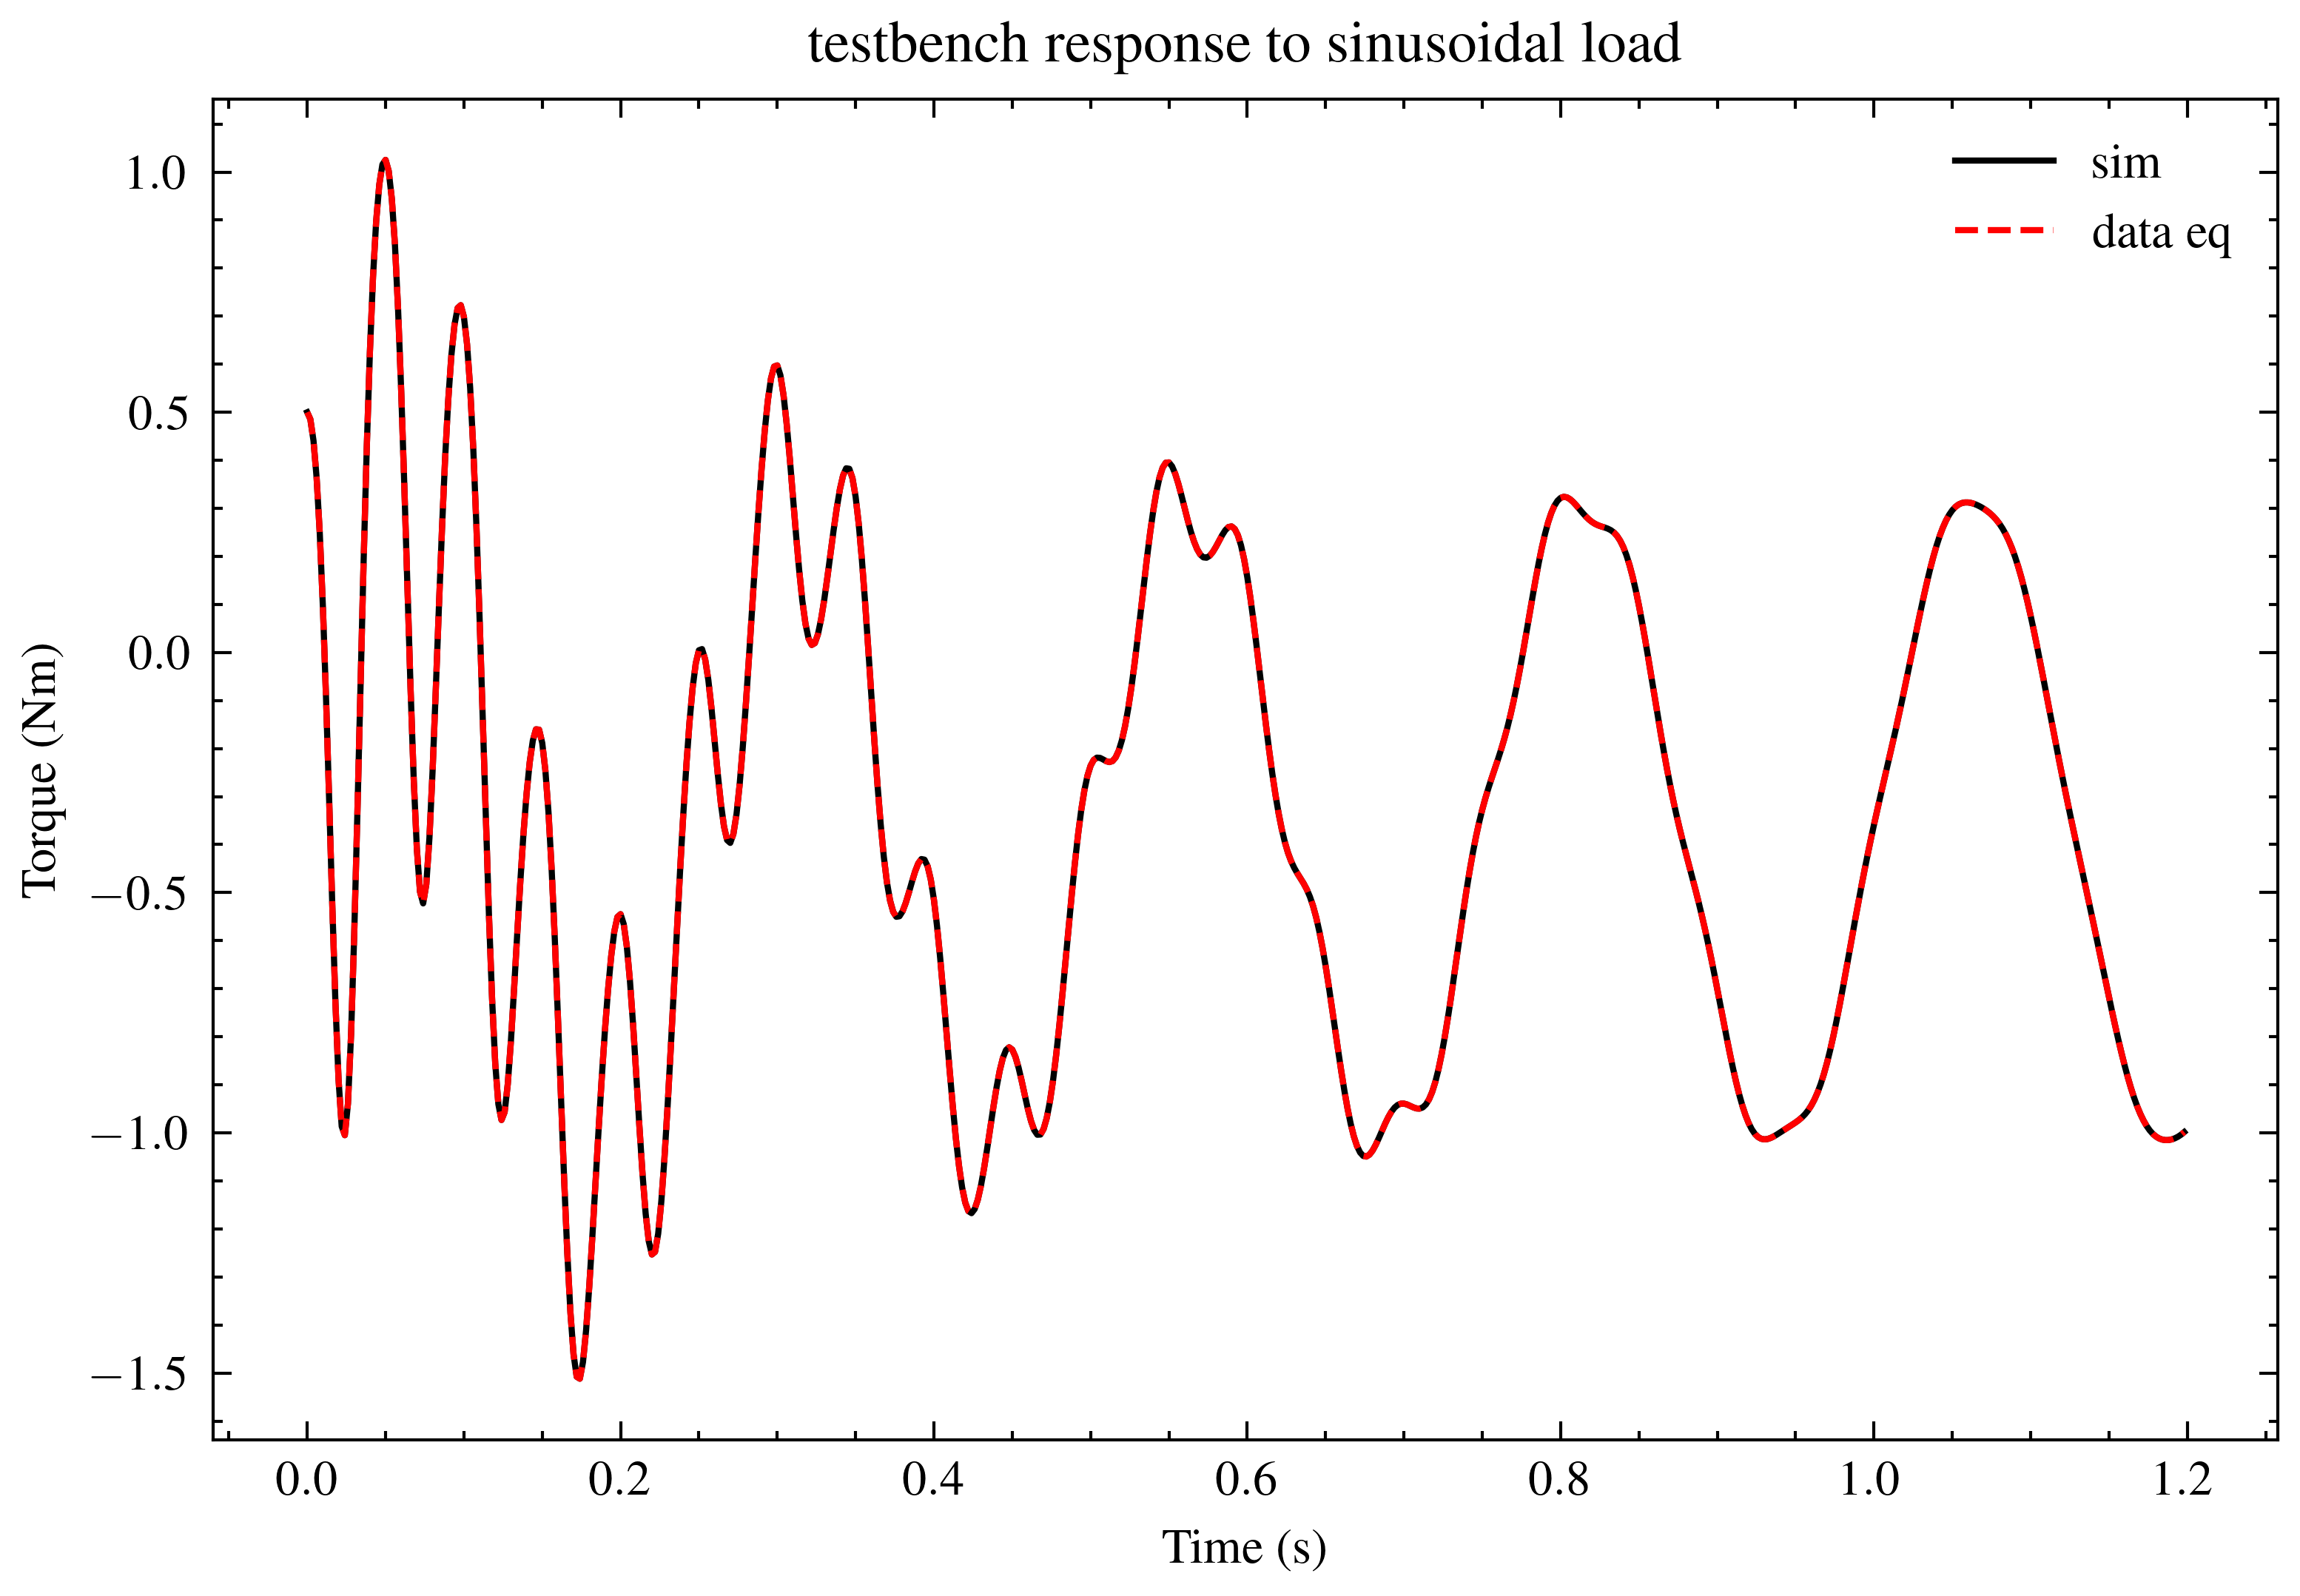

In [30]:
plt.plot(t, dyout_sin[:,0], label='sim')
plt.plot(t, meases_sin[0,:], label='data eq')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('testbench response to sinusoidal load')
plt.show()

In [31]:
Y_sin = np.reshape(dyout_sin, (-1,1))
noisy_meas_sin = Y_sin + e

In [32]:
u_hat_sin, x_hat_sin = tikhonov_problem(noisy_meas_sin, O_, G, D_, lam=0.05)
u_hat_l_sin, x_hat_l_sin = lasso_problem(noisy_meas_sin, O_, G, D_, lam=0.05)

In [33]:
print('Initial state estimate (Tikhonov):\n', x_hat_sin)
print('Initial state estimate (LASSO):\n', x_hat_l_sin,)

Initial state estimate (Tikhonov):
 [[0.1774776 ]
 [0.49807783]
 [0.0005408 ]
 [0.00260742]
 [0.00314093]]
Initial state estimate (LASSO):
 [[0.49804542]
 [0.50704824]
 [0.0076078 ]
 [0.00750517]
 [0.00708713]]


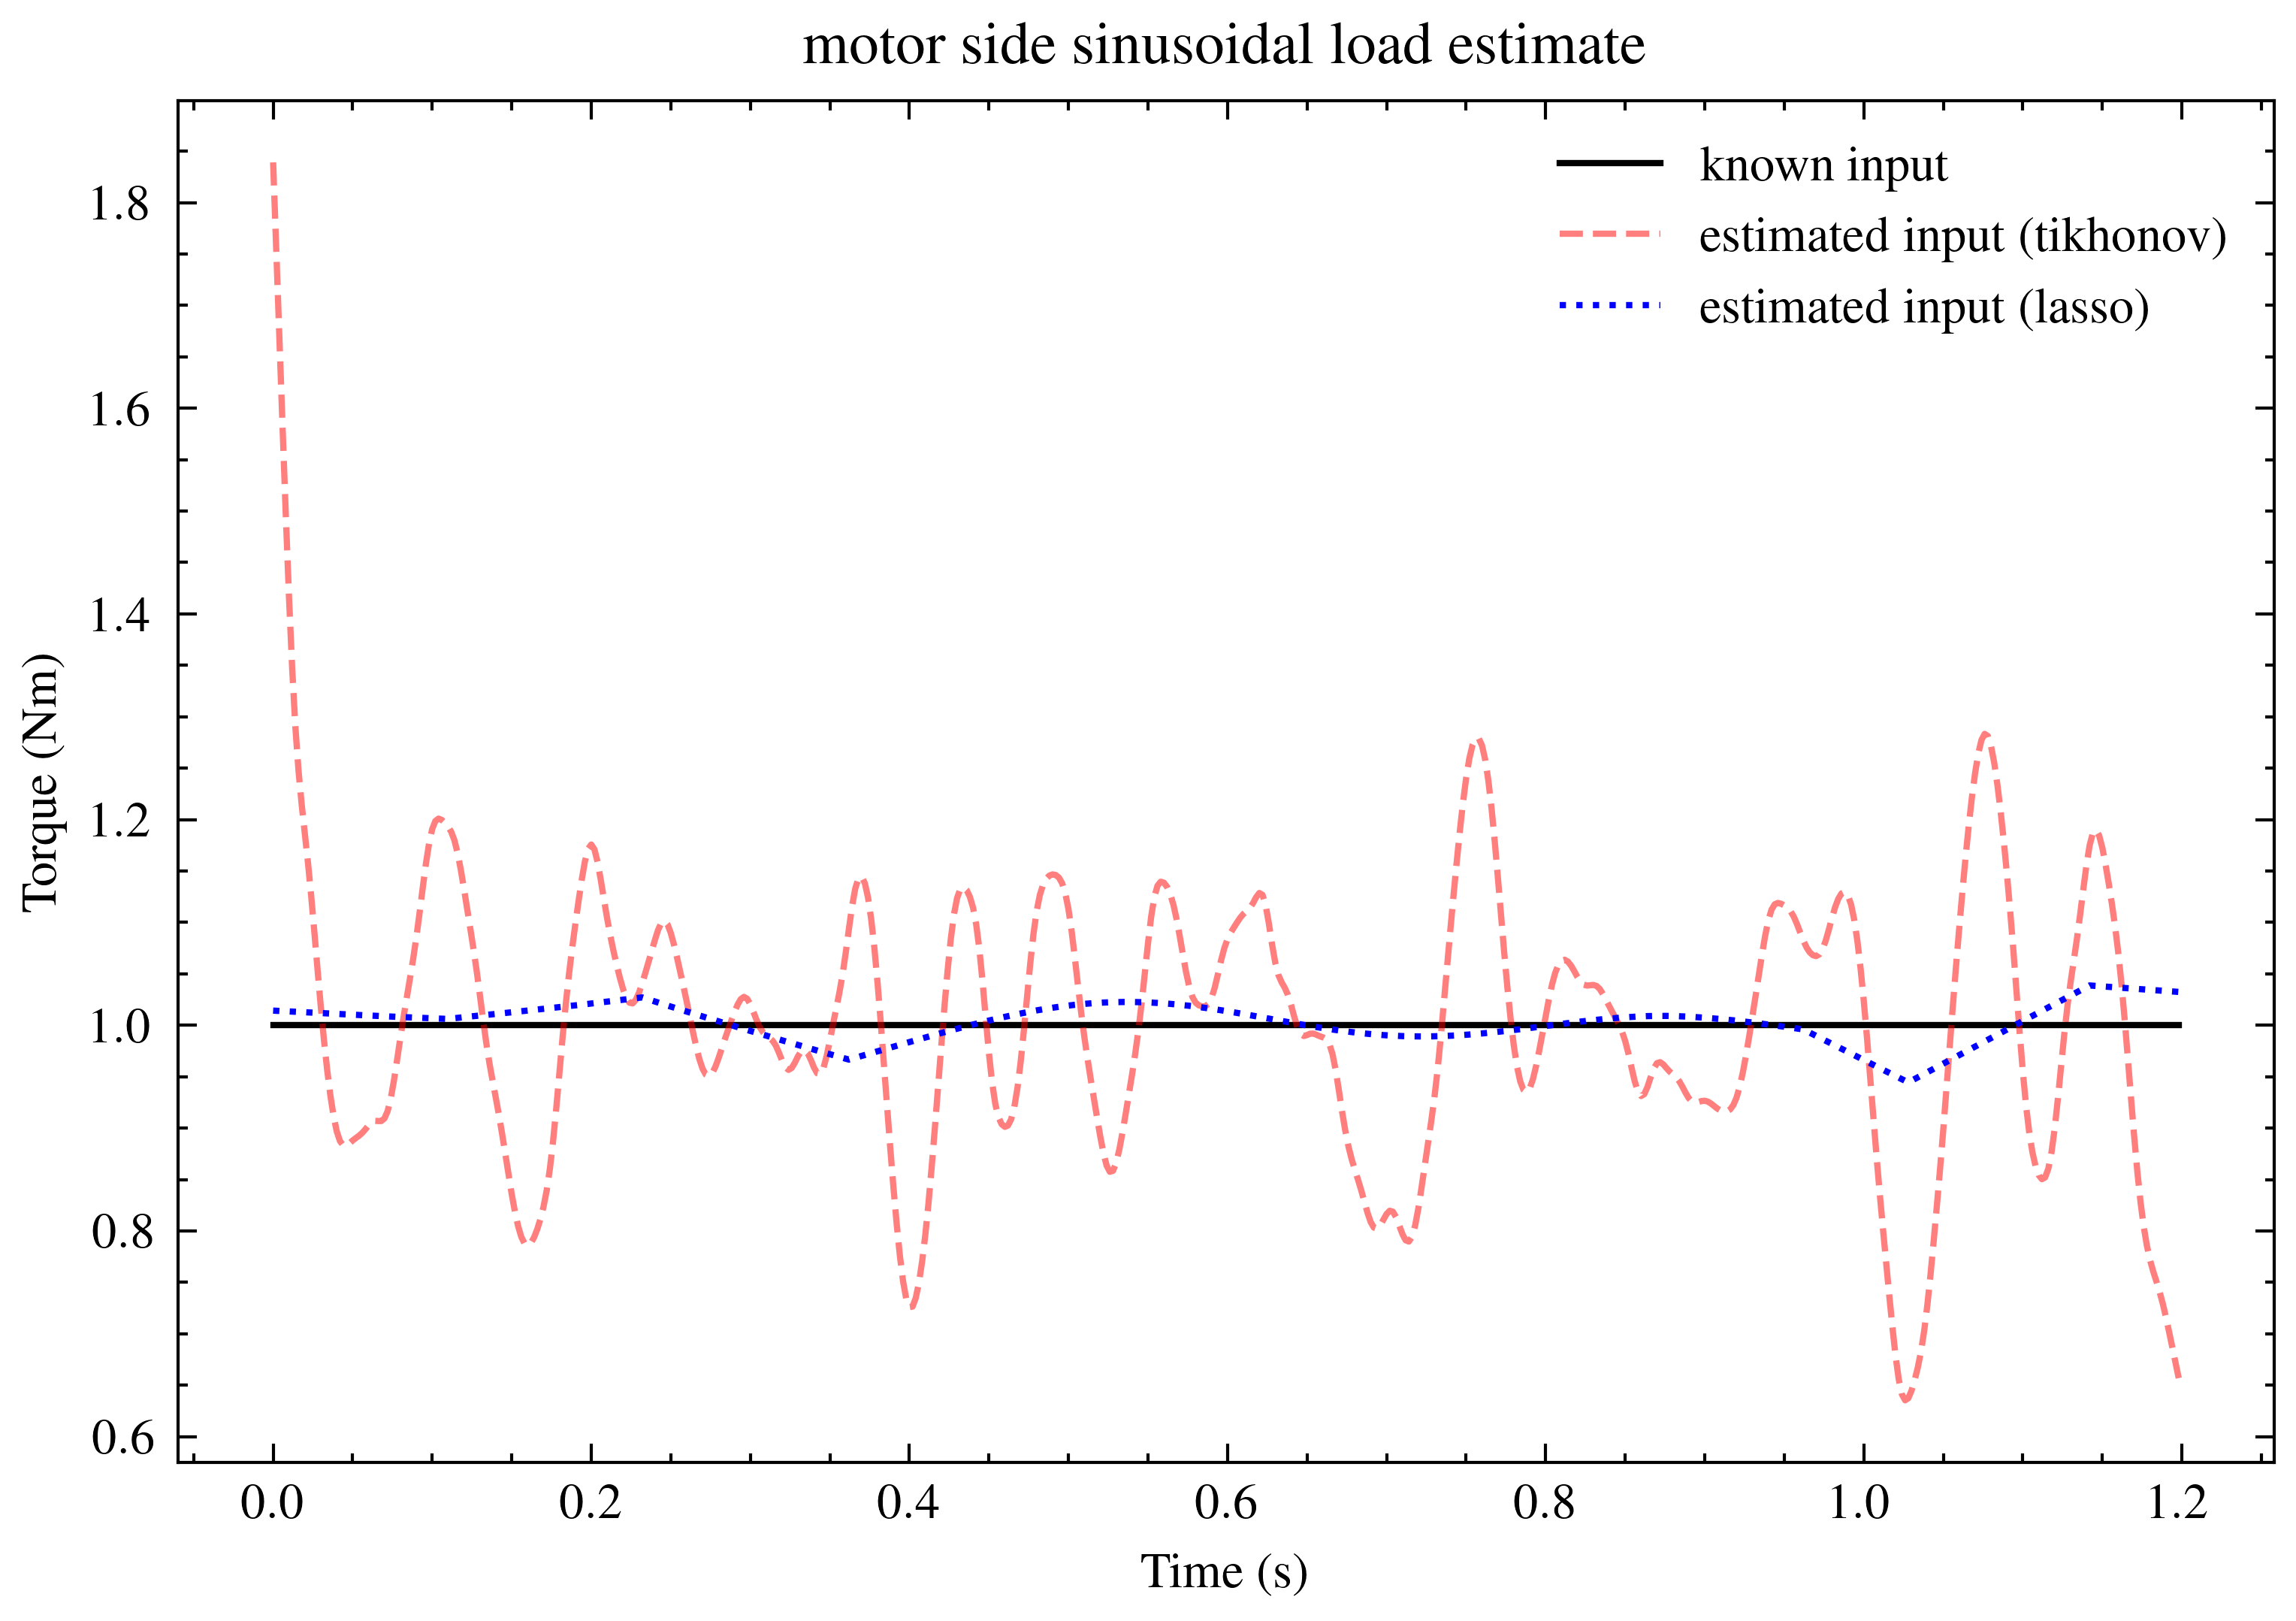

In [34]:
plt.plot(t, sin_ex_reshaped[::2], label='known input')
plt.plot(t, u_hat_sin[::2], label='estimated input (tikhonov)', alpha=0.5)
plt.plot(t, u_hat_l_sin[::2], label='estimated input (lasso)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('motor side sinusoidal load estimate')
plt.show()

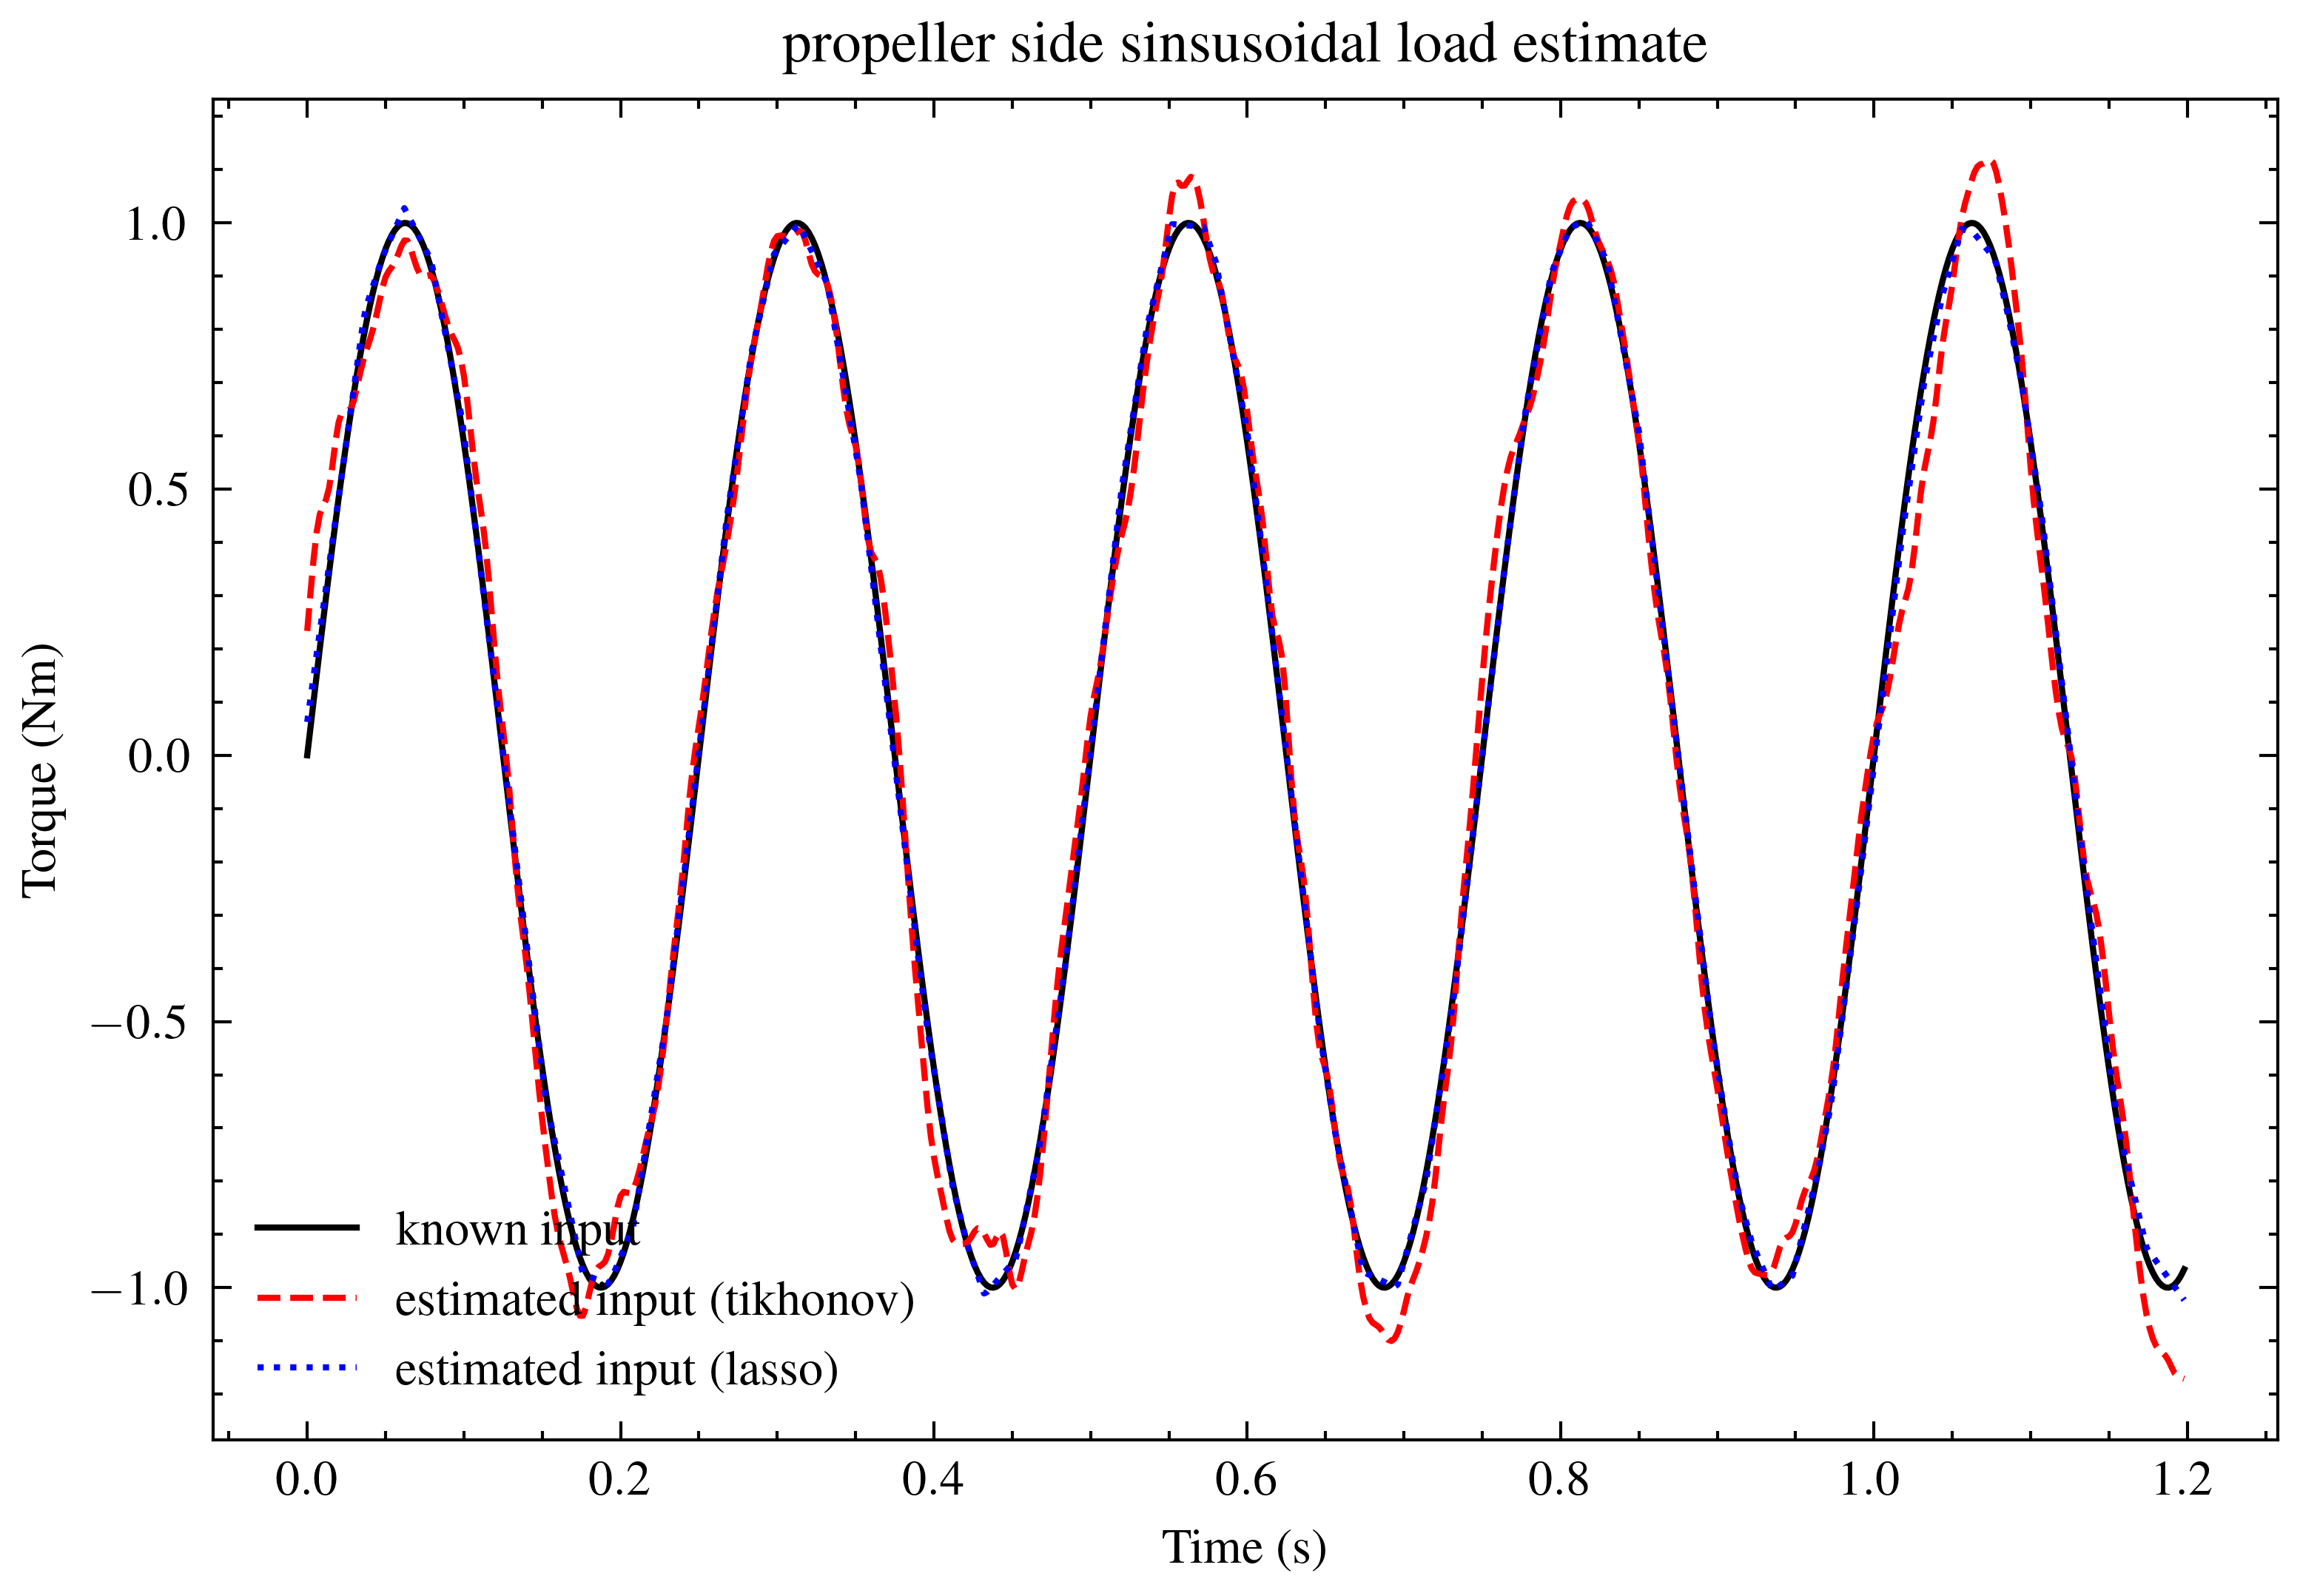

In [35]:
plt.plot(t, sin_ex_reshaped[1::2], label='known input')
plt.plot(t, u_hat_sin[1::2], label='estimated input (tikhonov)')
plt.plot(t, u_hat_l_sin[1::2], label='estimated input (lasso)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('propeller side sinsusoidal load estimate')
plt.show()

# Test input and state estimation with consequent measurement batches

In [36]:
sim_time = np.arange(0, 10, 0.001)
dst = np.mean(np.diff(sim_time))
en = len(sim_time)
em = B.shape[1]

U = np.zeros((len(sim_time), 2))

e1 = np.random.normal(0, .01, U.shape[0])
e2 = np.random.normal(0, .01, U.shape[0])

U[:,0] += 5 + e1
U[:,1] -= 2 + np.sin(5*2*np.pi*sim_time) + e2

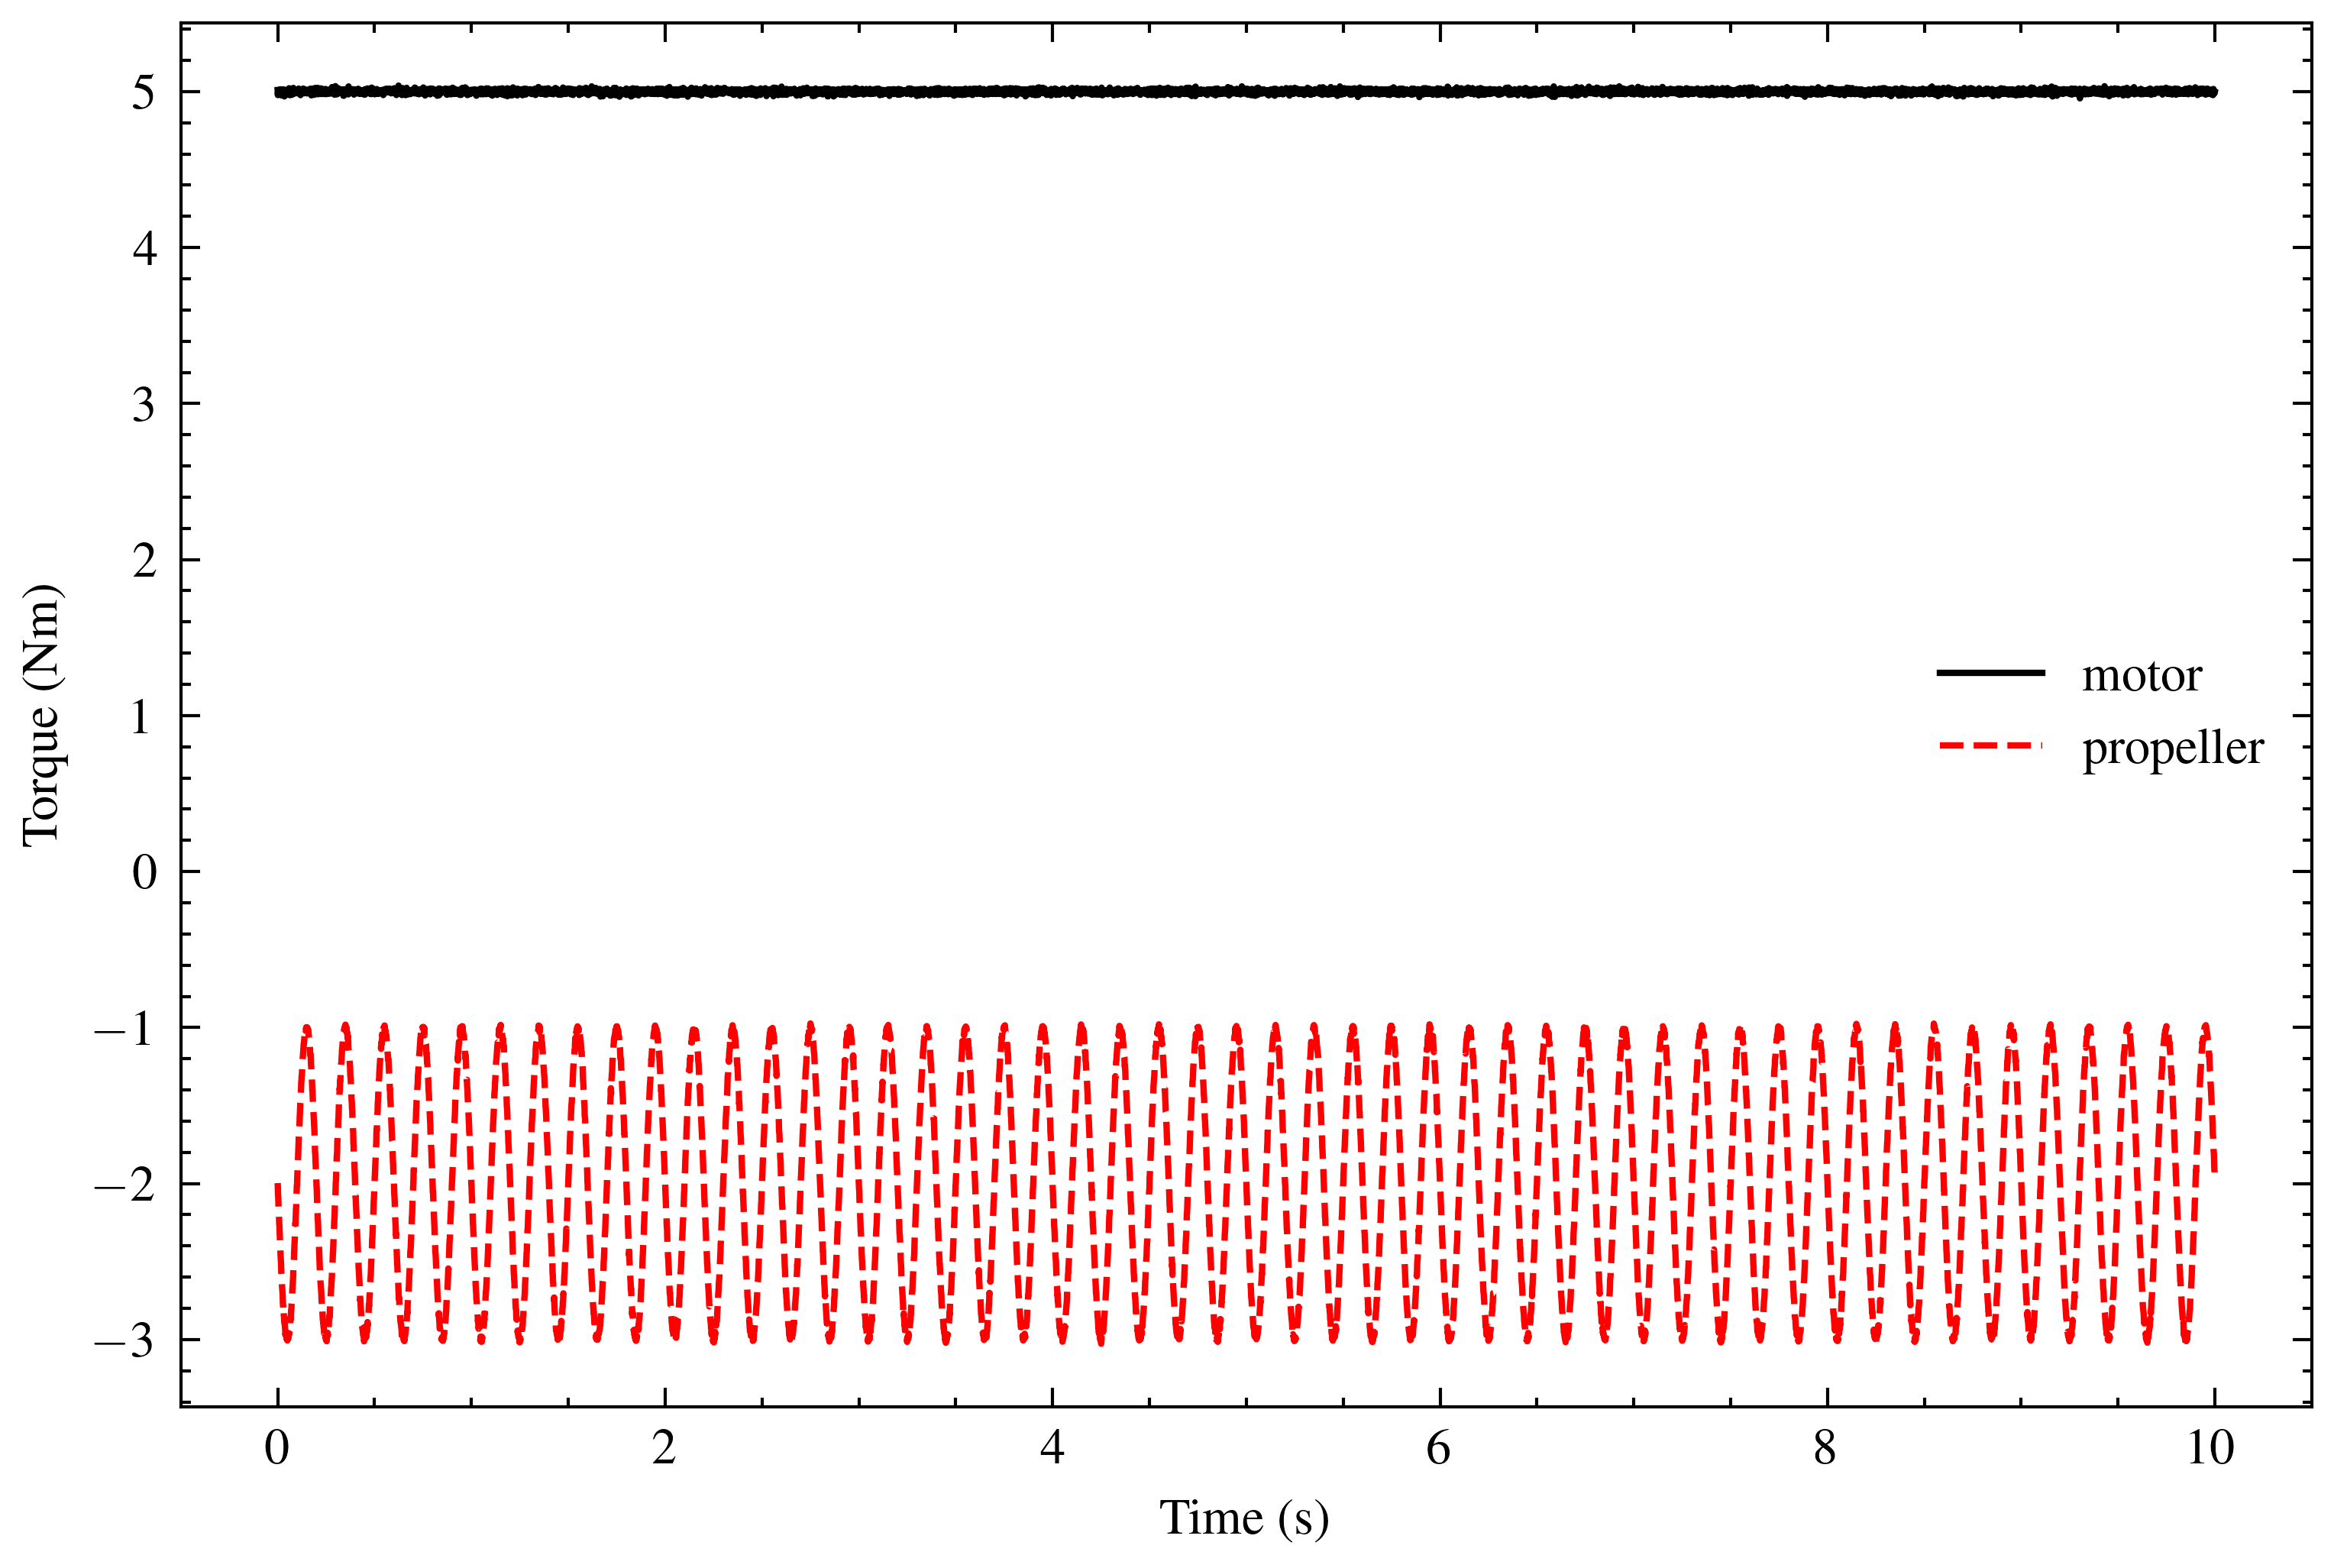

In [37]:
plt.plot(sim_time, U, label=('motor', 'propeller'))
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.show()

In [38]:
time_meas, measurements, _ = dlsim((A, B, C, D, dst), U, t=sim_time)

In [39]:
measurement_error = np.random.normal(0, .02, measurements.shape[0]).reshape(-1,1)
measurements_noise = measurements + measurement_error

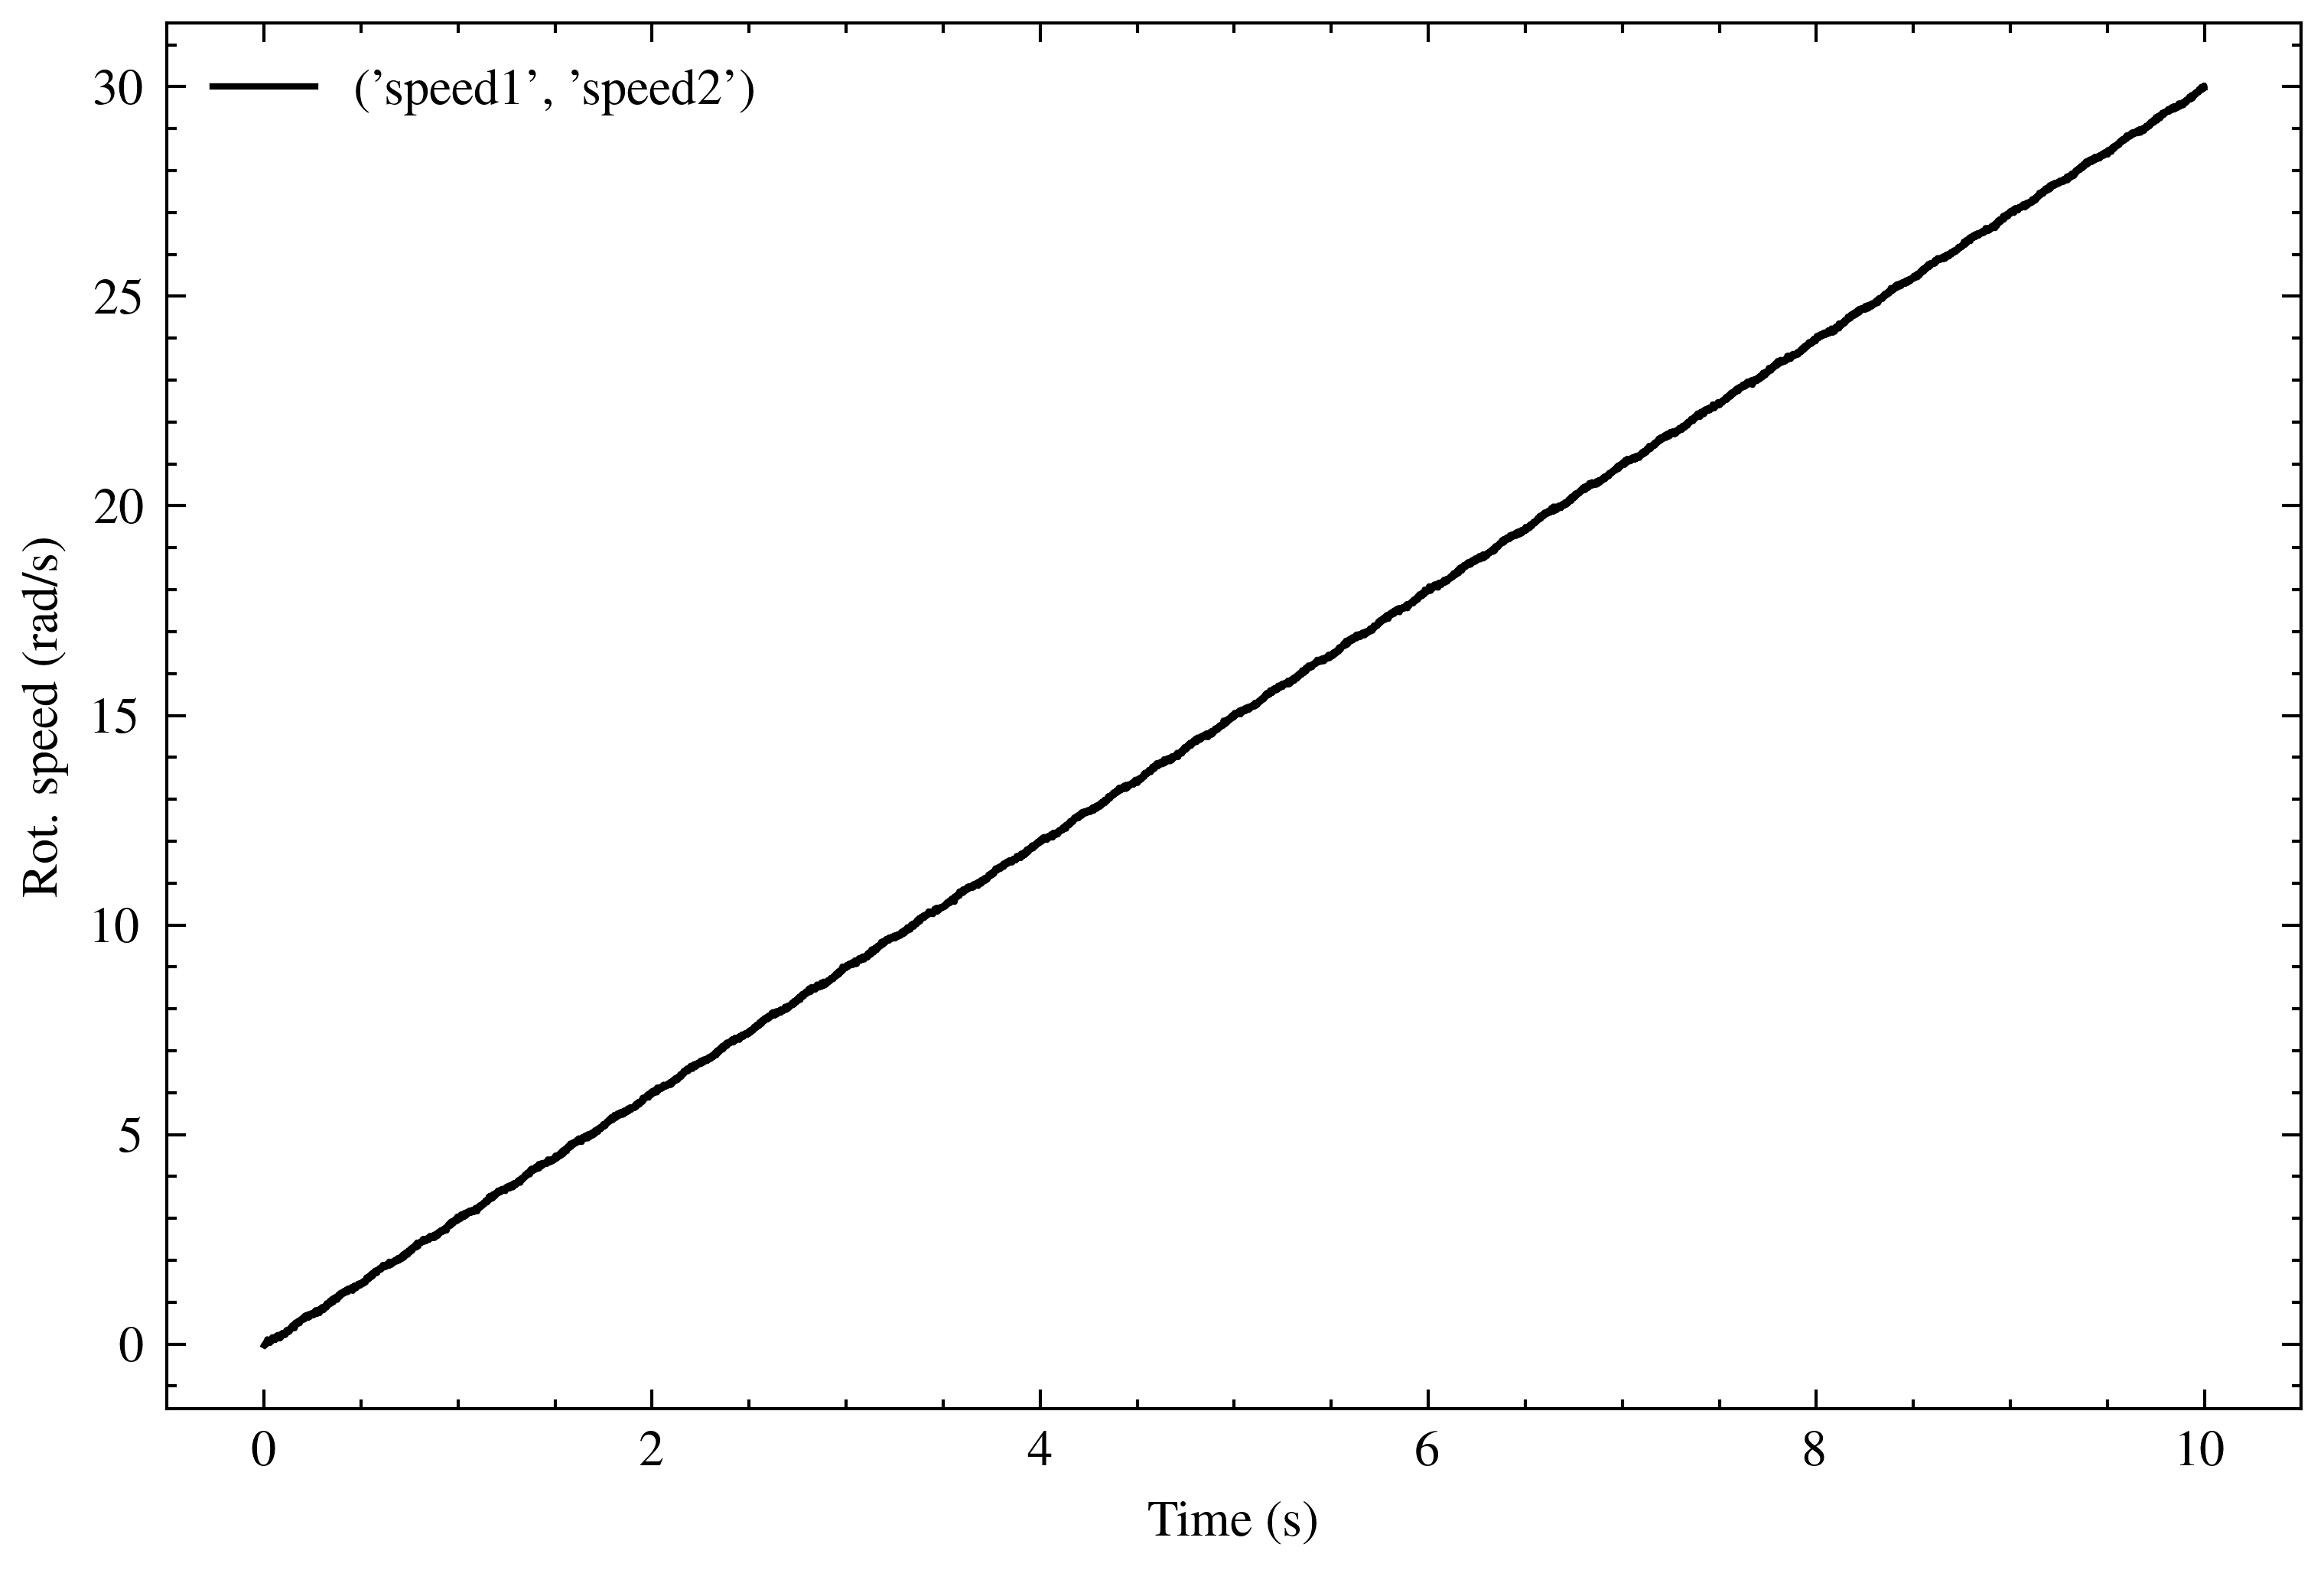

In [40]:
plt.plot(time_meas, measurements_noise[:,1:], label=('speed1', 'speed2'))
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Rot. speed (rad/s)')
plt.xlim()
plt.ylim()
plt.show()

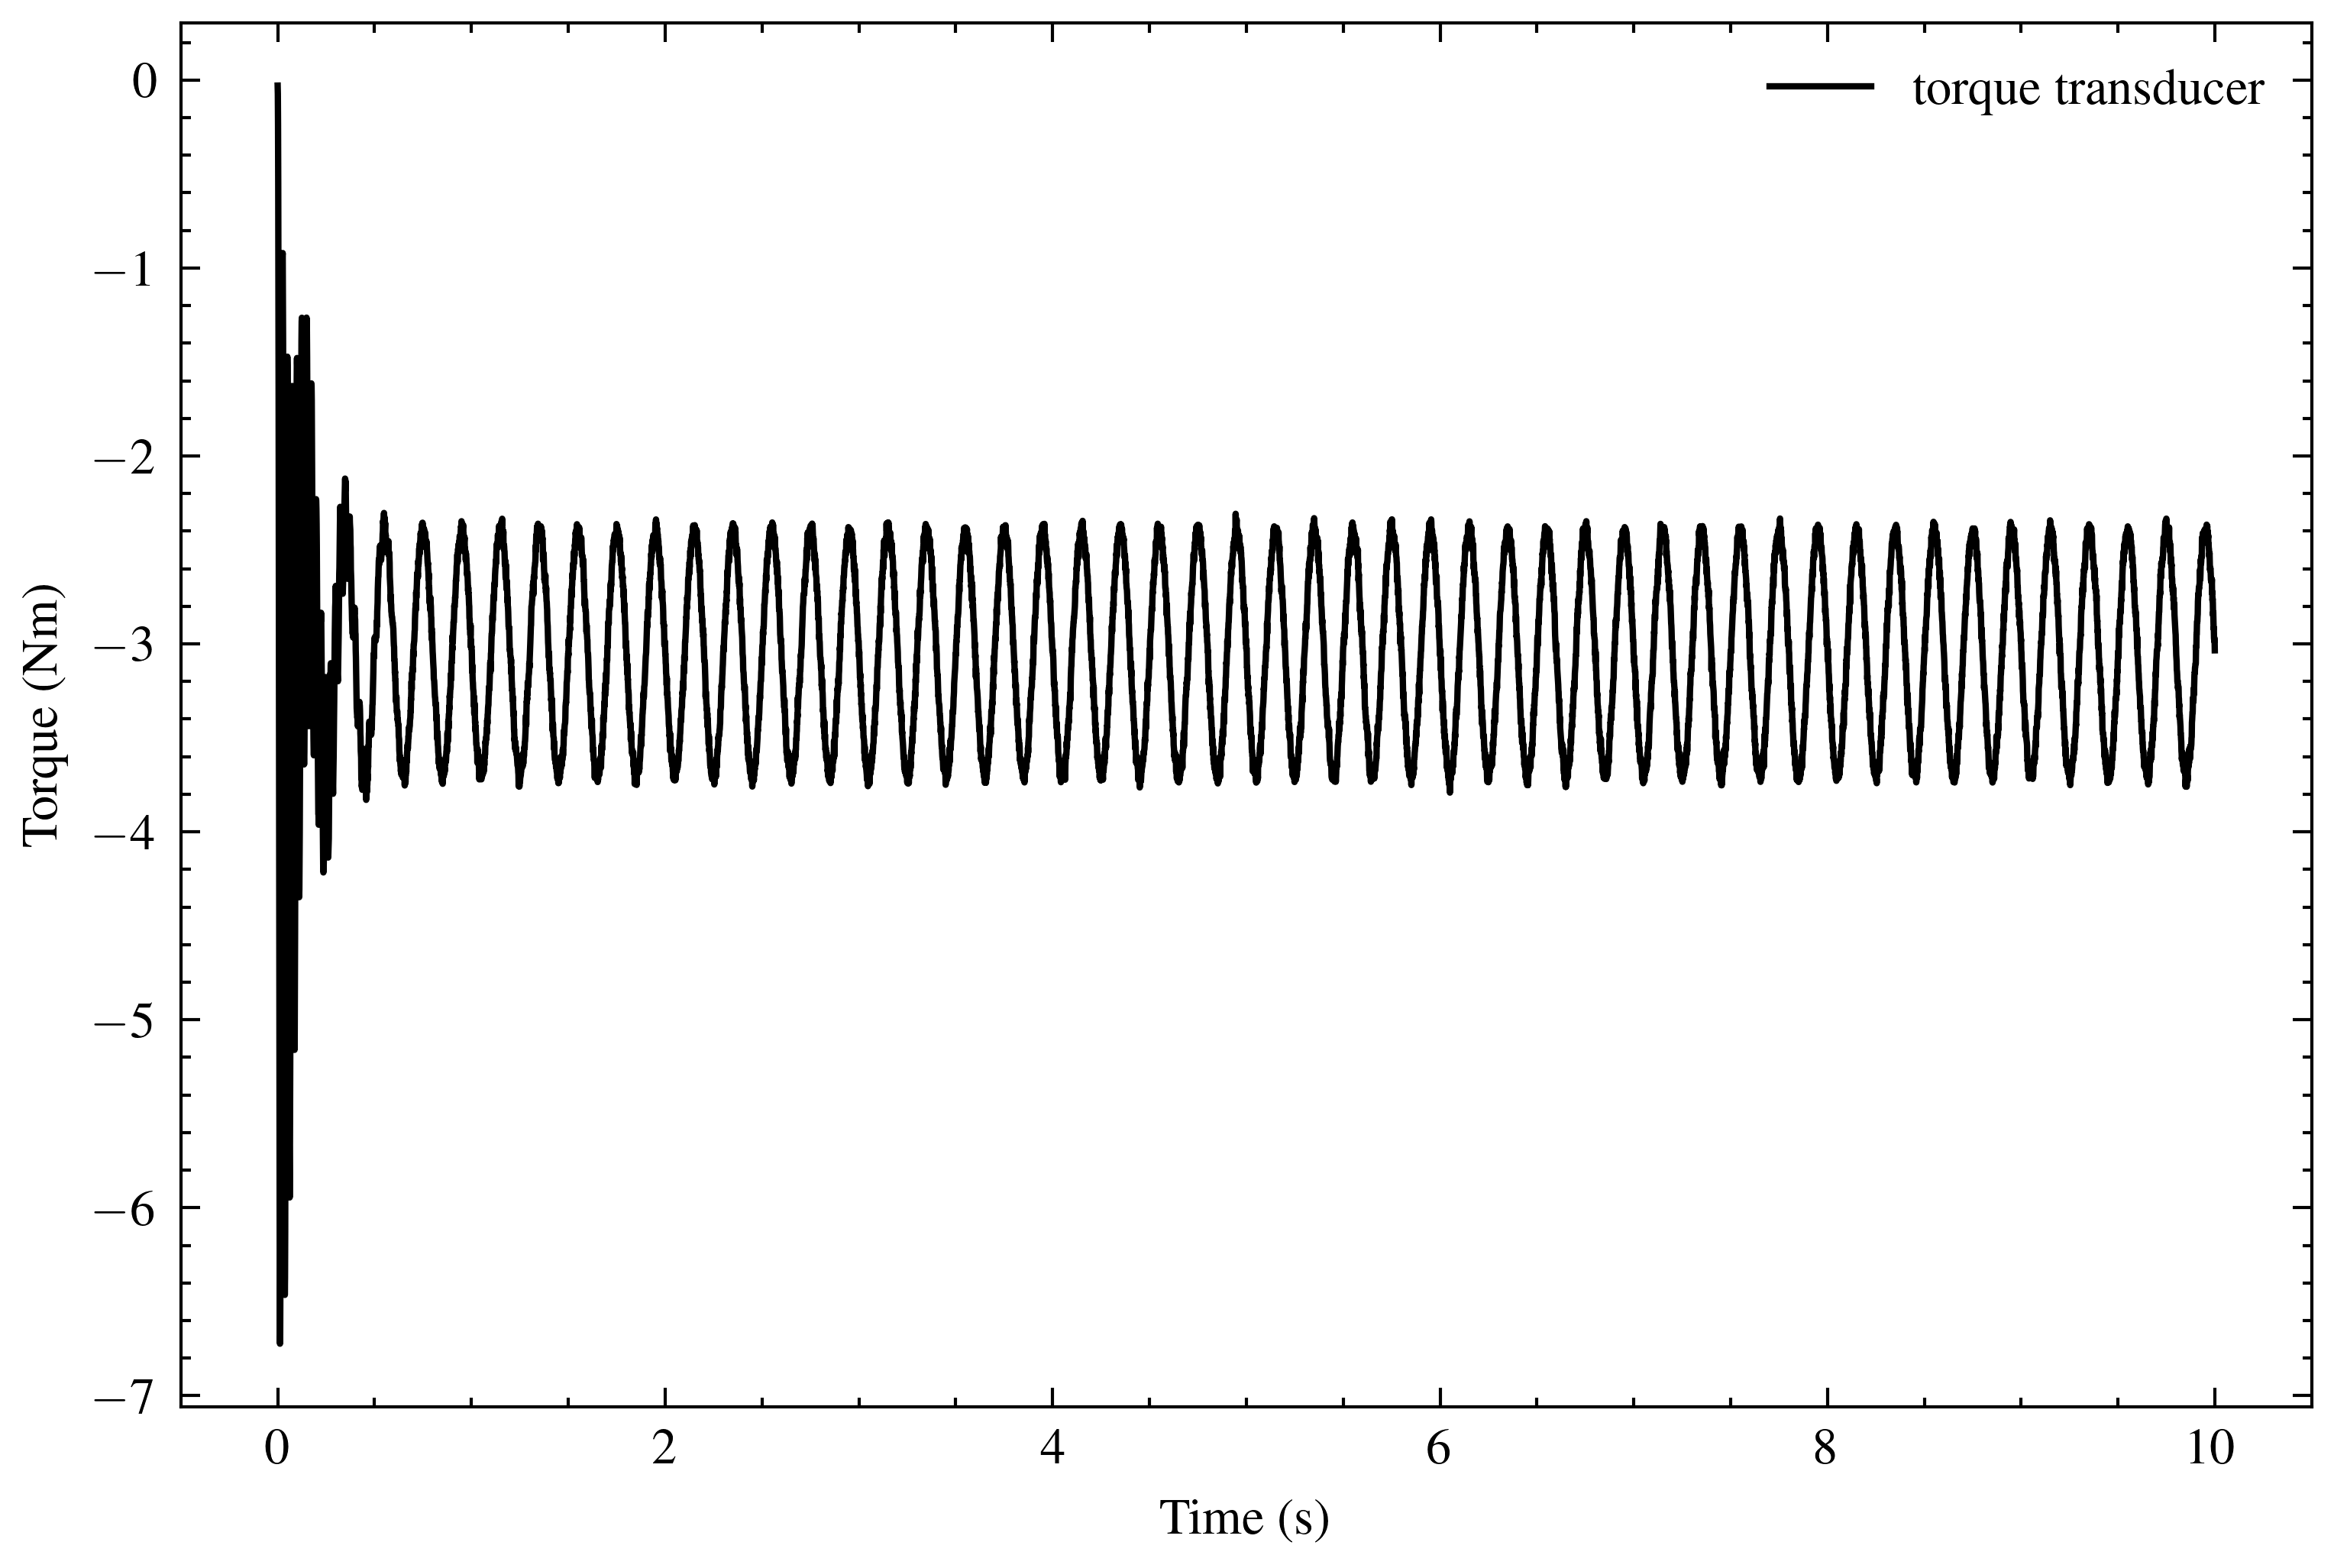

In [41]:
plt.plot(time_meas, measurements_noise[:,0], label='torque transducer')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.show()

In [42]:
bs = 500 # batch size
loop_len = int(en/bs)

D2_mat = second_difference_matrix(bs, em)
O_mat = O(A, C, bs)
G_mat = gamma(A, B, C, bs)
X0_t = None
X0_l = None

tikh_estimates = []
lasso_estimates = []

In [43]:
for i in range(loop_len):
    batch = measurements_noise[i*bs:(i+1)*bs,:]
    #en = batch.shape[0]
    y_noise = batch.reshape(-1,1)
    tikhonov_estimate, x_tikhonov = tikhonov_problem(y_noise, O_mat, G_mat, D2_mat, initial_state=X0_t, lam=0.05)
    lasso_estimate, x_lasso = lasso_problem(y_noise, O_mat, G_mat, D2_mat, initial_state=X0_l, lam=0.05)
    print('Initial state estimate (Tikhonov):\n', x_tikhonov)
    print('Initial state estimate (LASSO):\n', x_lasso)
    #X0_t = x_tikhonov
    #X0_l = x_lasso
    tikh_estimates.append(tikhonov_estimate)
    lasso_estimates.append(lasso_estimate)

Initial state estimate (Tikhonov):
 [[-0.97182998]
 [-0.02783637]
 [-0.01907474]
 [-0.01605551]
 [-0.0152272 ]]
Initial state estimate (LASSO):
 [[-0.06014581]
 [-0.02341896]
 [-0.0024914 ]
 [-0.00243098]
 [-0.00212091]]
Initial state estimate (Tikhonov):
 [[-3.13236245]
 [-2.97525823]
 [ 1.45087449]
 [ 1.4502085 ]
 [ 1.45055893]]
Initial state estimate (LASSO):
 [[-3.70930486]
 [-2.98011943]
 [ 1.43813767]
 [ 1.43811445]
 [ 1.43834705]]
Initial state estimate (Tikhonov):
 [[-3.1735623 ]
 [-3.00805503]
 [ 3.01178493]
 [ 3.01093787]
 [ 3.01036124]]
Initial state estimate (LASSO):
 [[-3.61141491]
 [-3.00207451]
 [ 3.00574001]
 [ 3.00484794]
 [ 3.00352617]]
Initial state estimate (Tikhonov):
 [[-3.15469383]
 [-3.05646133]
 [ 4.4521724 ]
 [ 4.45122977]
 [ 4.45254986]]
Initial state estimate (LASSO):
 [[-3.72692378]
 [-3.05233608]
 [ 4.43856401]
 [ 4.43848923]
 [ 4.43956959]]
Initial state estimate (Tikhonov):
 [[-3.3239613 ]
 [-3.03291896]
 [ 6.00559391]
 [ 6.00447815]
 [ 6.00400778]]
Init

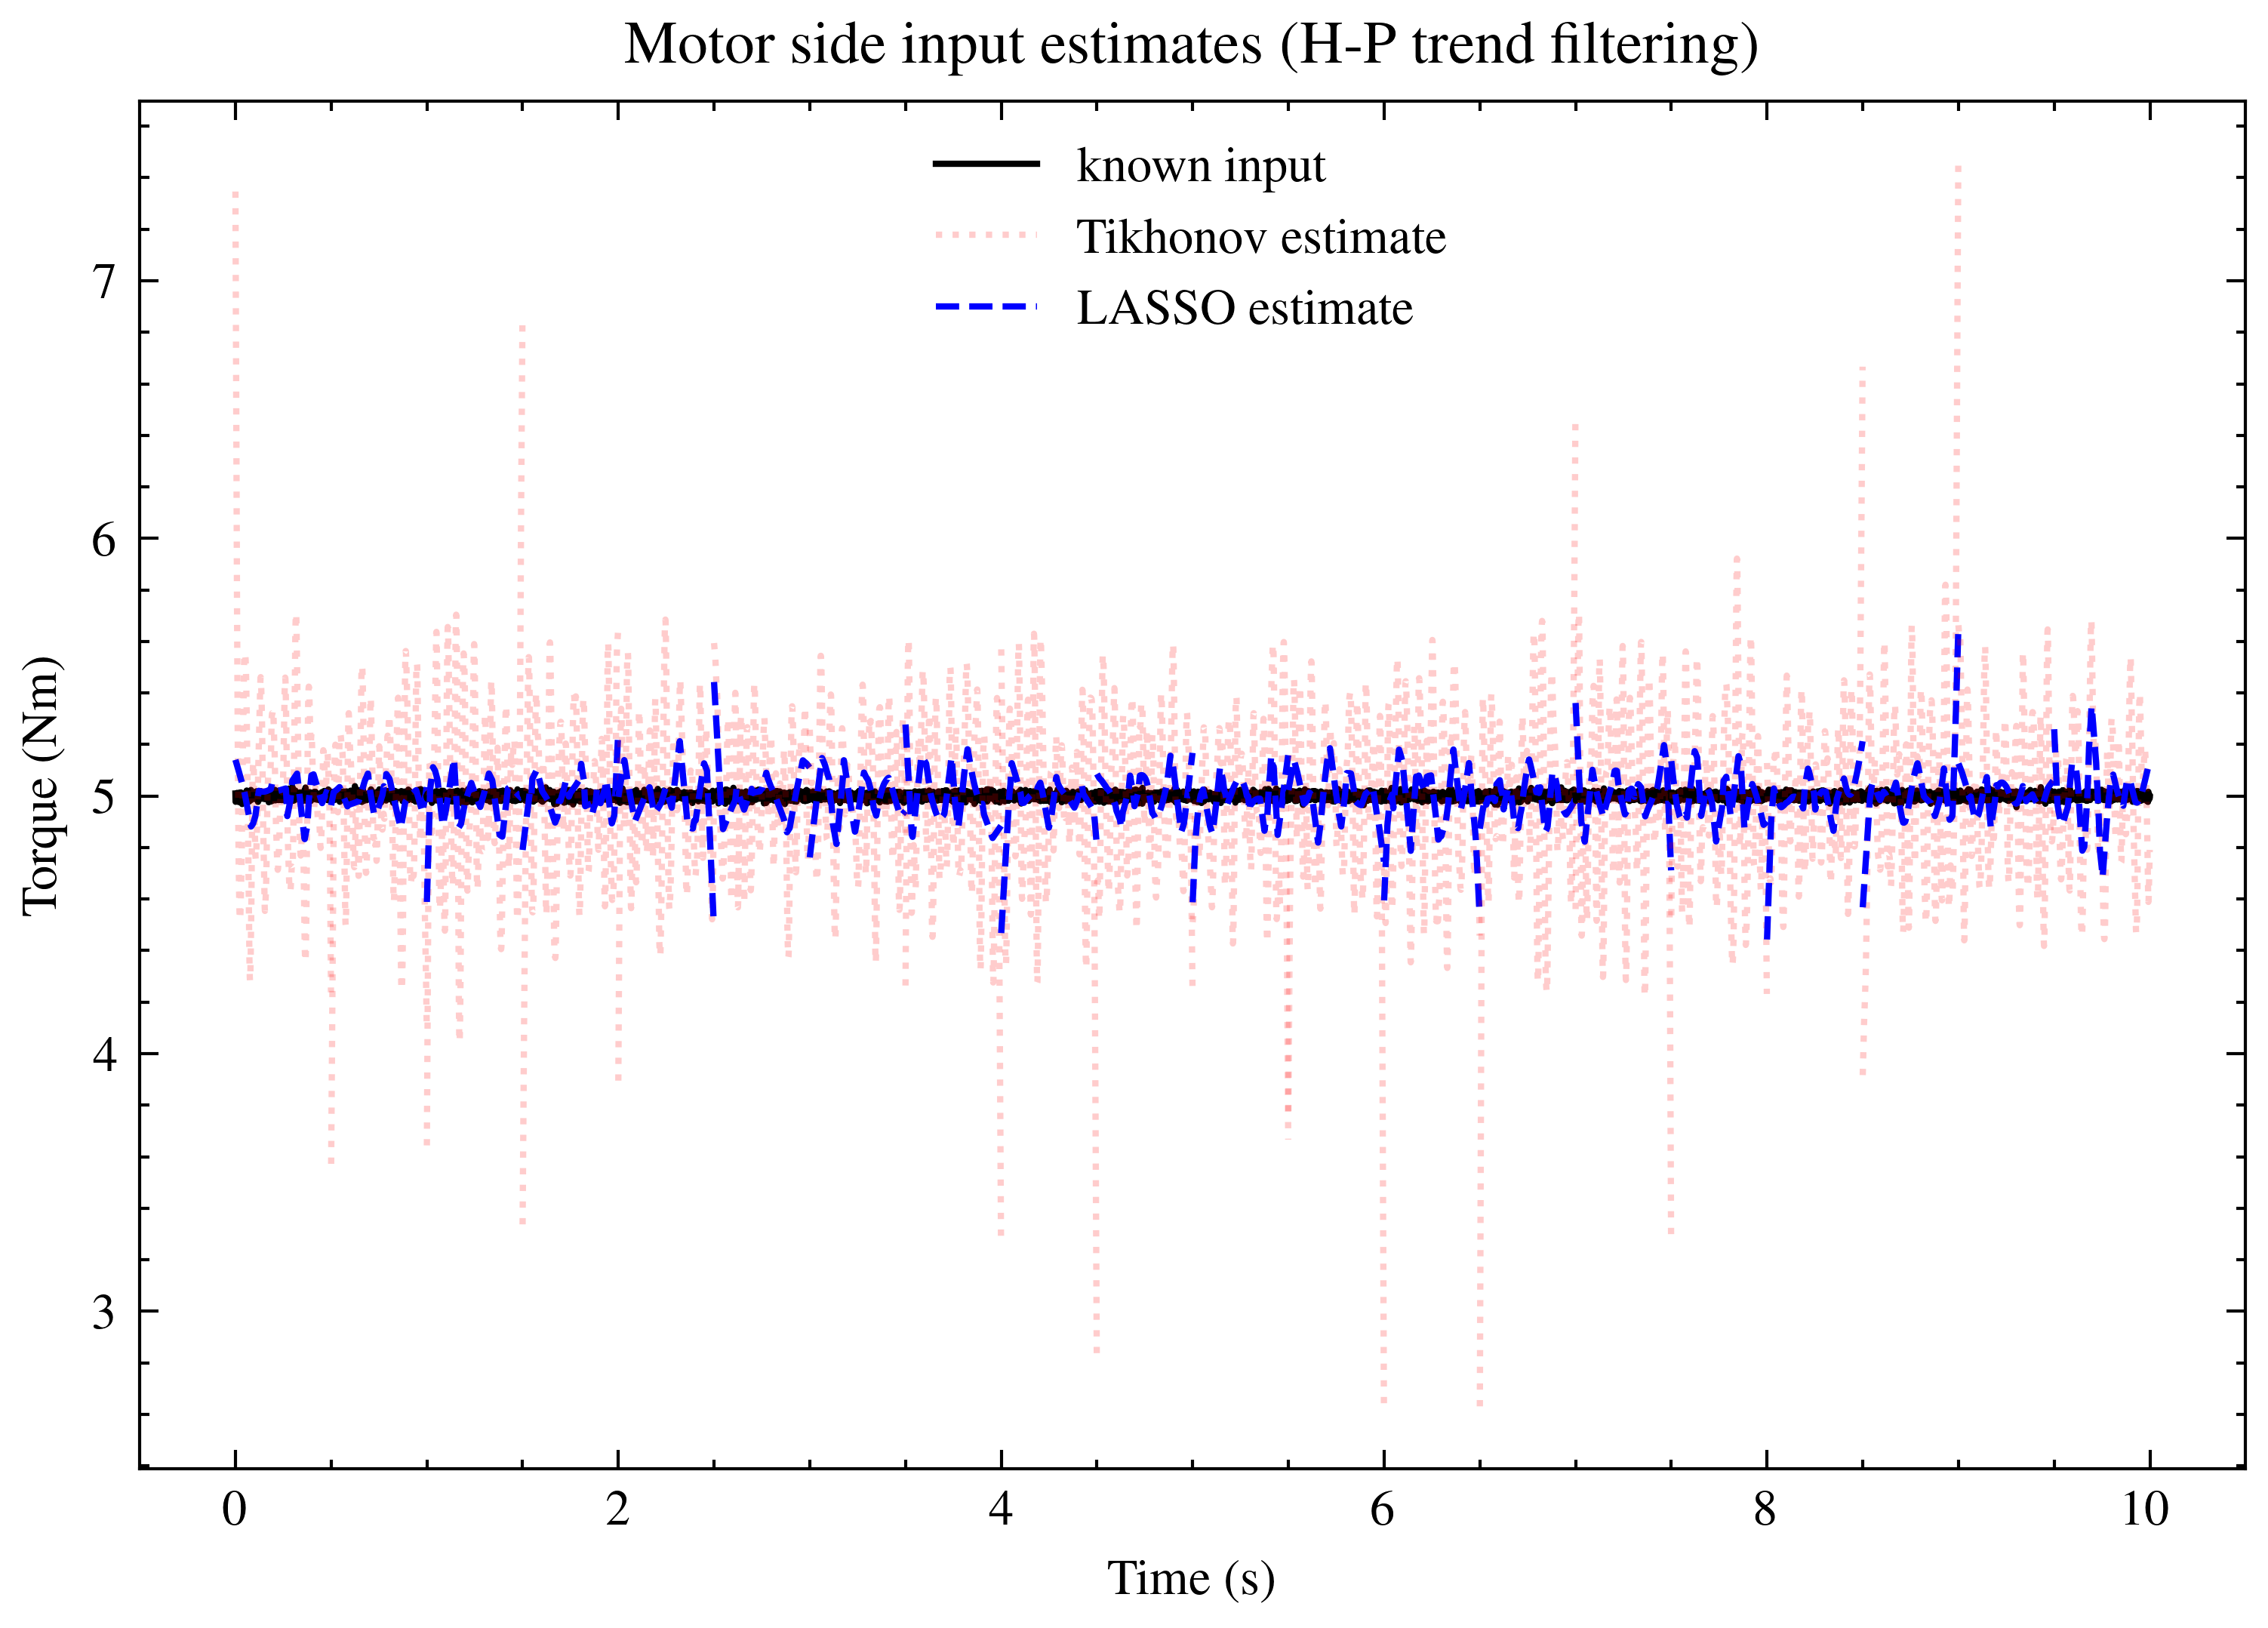

In [51]:
for i in range(loop_len):
    plt.plot(sim_time[i*bs:(i+1)*bs], U[i*bs:(i+1)*bs,0], linestyle='solid', color='black')
    plt.plot(sim_time[i*bs:(i+1)*bs], tikh_estimates[i][::2], linestyle='dotted', alpha=0.2, color='red')
    plt.plot(sim_time[i*bs:(i+1)*bs], lasso_estimates[i][::2], linestyle='dashed', color='blue')

plt.legend(('known input', 'Tikhonov estimate', 'LASSO estimate'))
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('Motor side input estimates (H-P trend filtering)')
#plt.ylim(4.95, 5.05)
#plt.xlim(0.4,0.6)
plt.show()

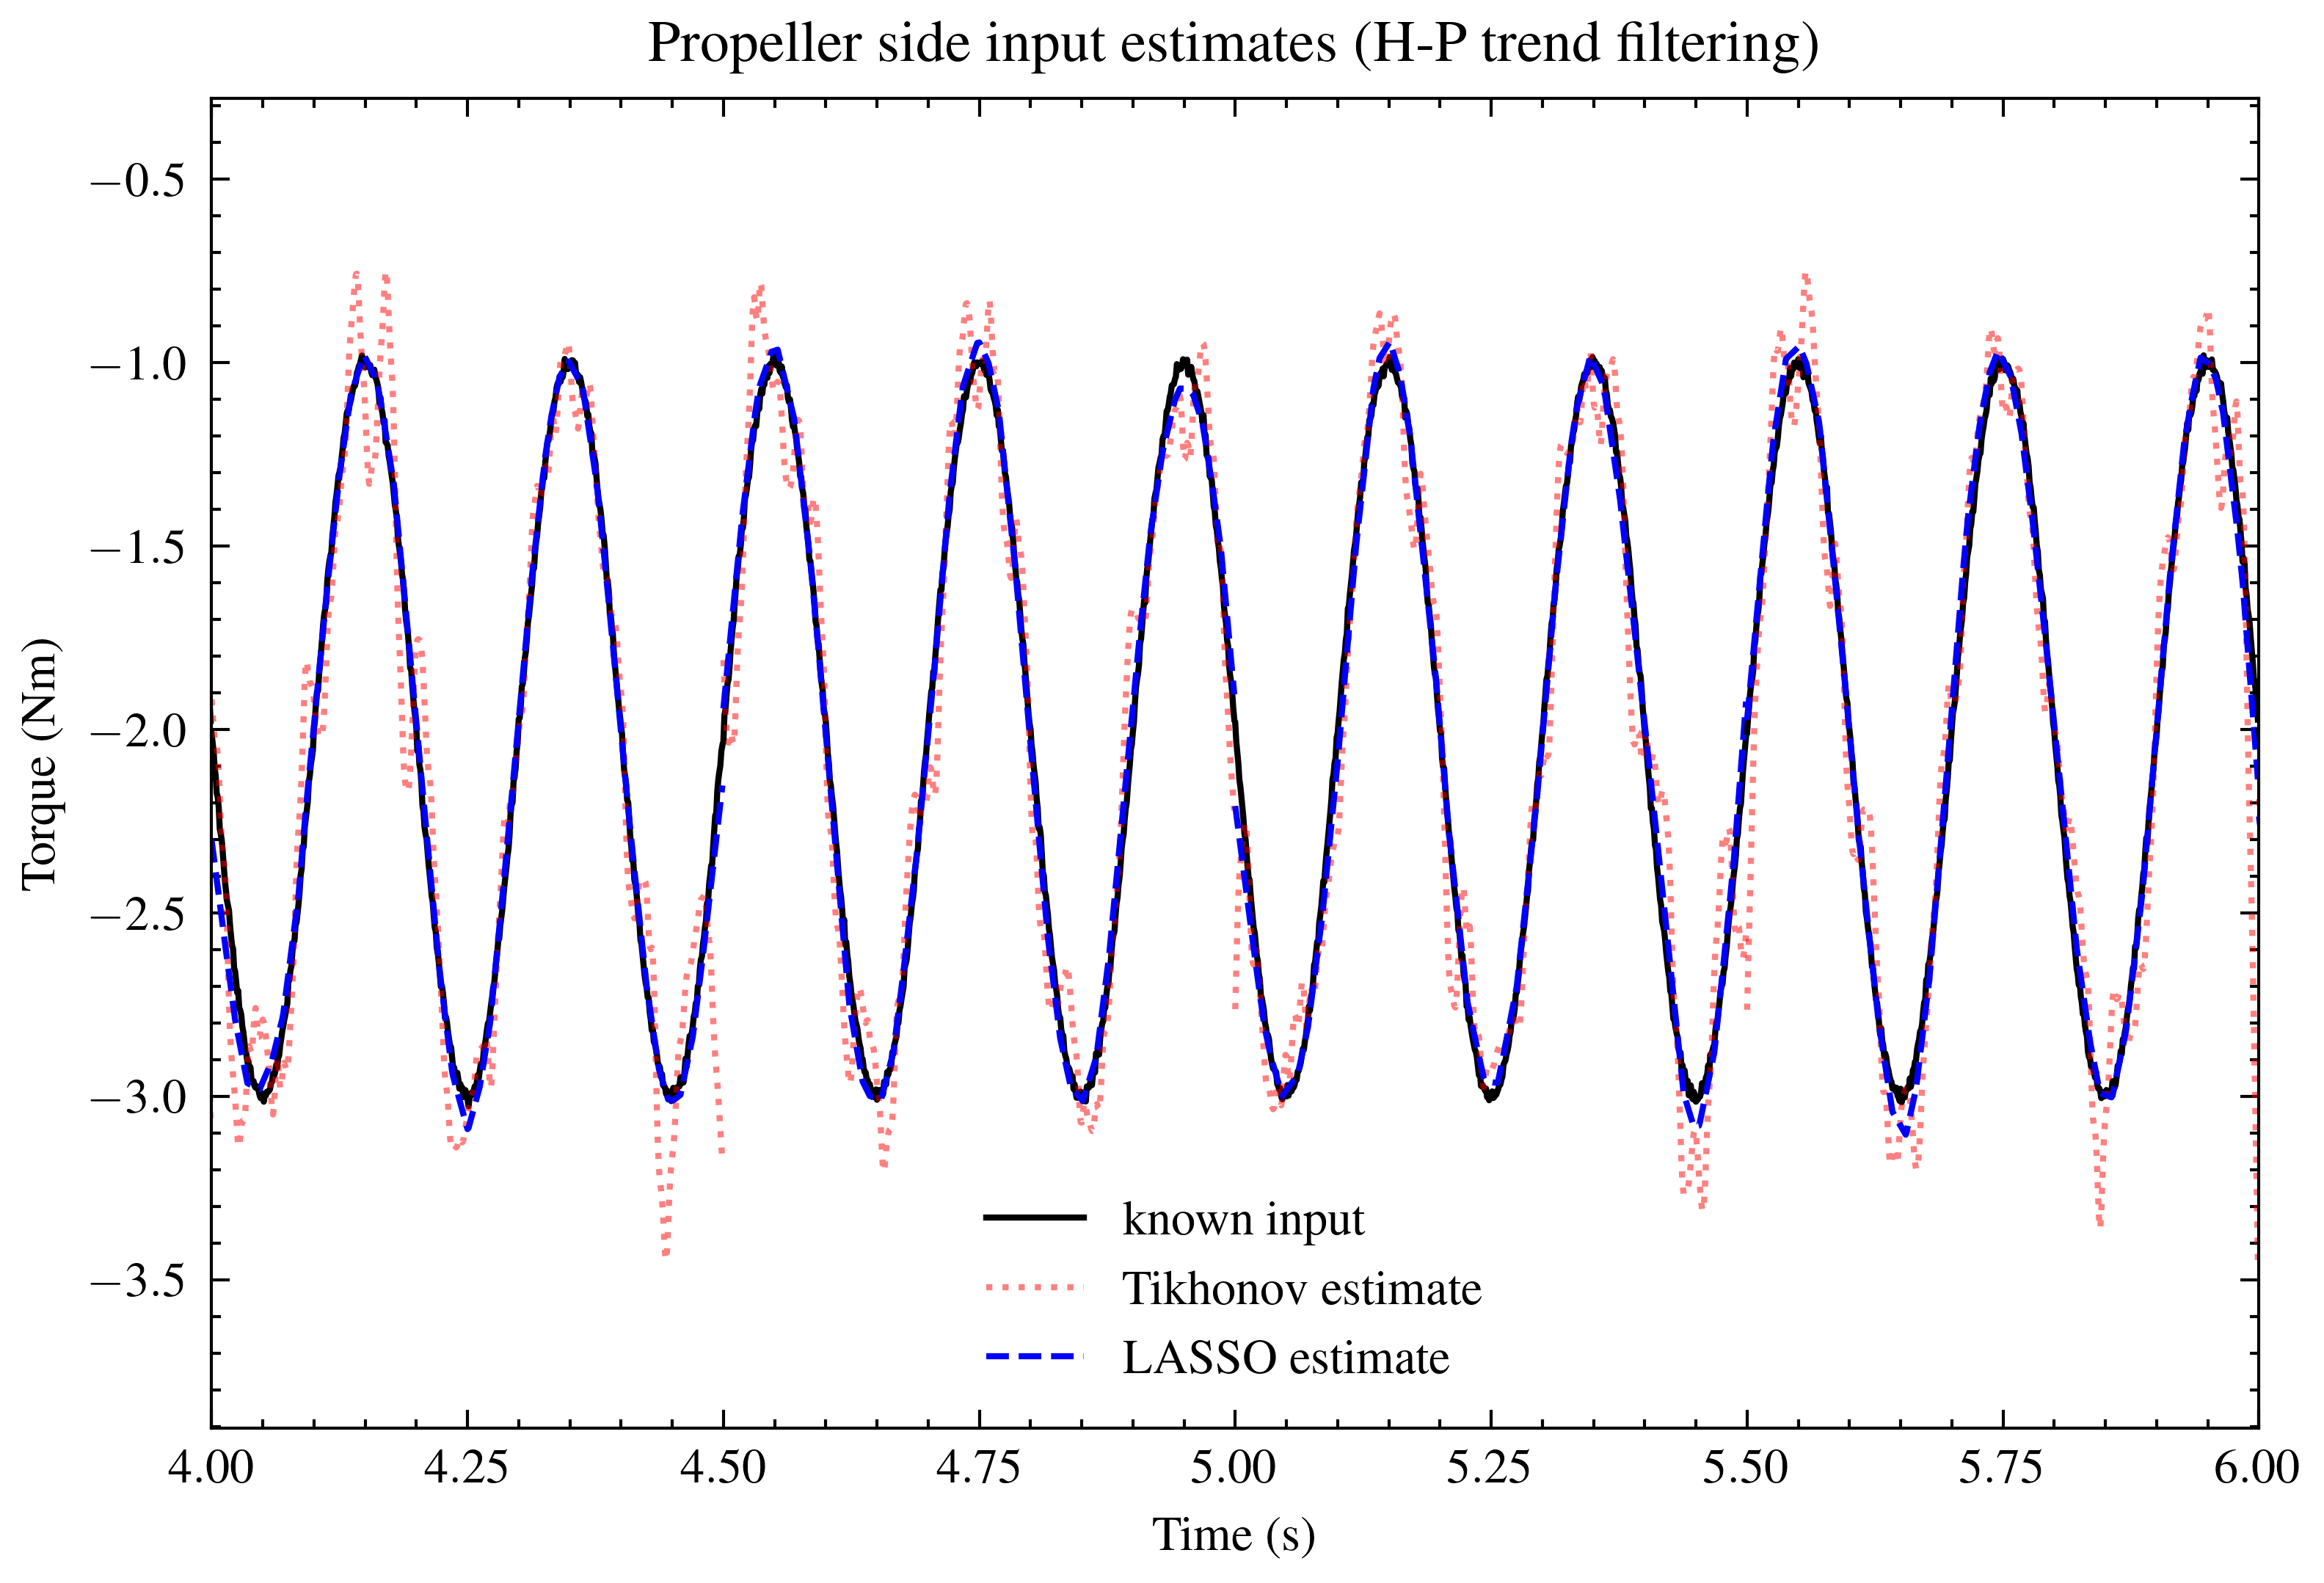

In [50]:
for i in range(loop_len):
    plt.plot(sim_time[i*bs:(i+1)*bs], U[i*bs:(i+1)*bs,1], linestyle='solid', color='black')
    plt.plot(sim_time[i*bs:(i+1)*bs], tikh_estimates[i][1::2], linestyle='dotted', alpha=0.5, color='red')
    plt.plot(sim_time[i*bs:(i+1)*bs], lasso_estimates[i][1::2], linestyle='dashed', color='blue')

plt.legend(('known input', 'Tikhonov estimate', 'LASSO estimate'))
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('Propeller side input estimates (H-P trend filtering)')
plt.xlim(4,6)
plt.show()